## Importing the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import logging
import scipy.stats as stats
from scipy.optimize import curve_fit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from joblib import Parallel, delayed
from dask.distributed import Client
import dask
import gc
import warnings
from pmdarima.arima import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pmdarima as pm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import joblib
import datetime

## Loading the datasets
The data is stored in the folder ./dataset.
The data is stored in the following files:
- Veenkampen_Air_Quality.csv
- Veenkampen_Meteorology.csv
- Veenkampen_Soil.csv
- Veenkampen_Fluxes.csv

After loading the data, the data is being cut to the desired time period.
The time period is from 2015-01-01 00:00:00 to 2023-12-31 23:59:59.

The first row is being removed because it contains the unit of the data.
Some information about the data is being printed like the number of missing values and the sampling rate.

In [3]:
# Define start and end date
start_date = '2015-01-01 00:00:00'
end_date = '2023-12-31 23:59:59'

# Function to preprocess the datasets
def prepare_dataset(df, start_date, end_date):
    # Create a copy of the DataFrame
    df = df.copy()
    
    # Convert Timestamp to datetime and set as index
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('Timestamp', inplace=True)
    
    # Trim the time period directly after setting the index
    df = df[start_date:end_date].copy()
    
    # Remove duplicate Timestamps (keep the first entry)
    df = df[~df.index.duplicated(keep='first')]
    
    # Convert all numeric columns to float
    for column in df.select_dtypes(include=['object']).columns:
        try:
            df.loc[:, column] = df[column].astype(float)
        except ValueError:
            print(f"Could not convert column {column} to float")
    
    return df

# Import and preprocess the datasets
air_quality = pd.read_csv('dataset/Veenkampen_Air Quality.csv', skiprows=[1])
air_quality = prepare_dataset(air_quality, start_date, end_date)

meteorology = pd.read_csv('dataset/Veenkampen_Meteorology.csv', skiprows=[1])
meteorology = prepare_dataset(meteorology, start_date, end_date)

soil = pd.read_csv('dataset/Veenkampen_Soil.csv', skiprows=[1])
soil = prepare_dataset(soil, start_date, end_date)

# Import and preprocess the Flux dataset
fluxes = pd.read_csv('./dataset/Veenkampen_Fluxes.csv', skiprows=[1]) # Remove the unit row
fluxes = prepare_dataset(fluxes, start_date, end_date)

# Show information about all preprocessed datasets
print("\nTime range of the datasets:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(f"Start: {df.index.min()}")
    print(f"End: {df.index.max()}")
    print(f"Number of data points: {len(df)}")

# Show information about the datasets
print("\nDataset Infos:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name} Dataset Info:")
    print(df.info())

# Check for missing values
print("\nMissing values:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\nMissing values in {name}:")
    print(df.isnull().sum())

# Check sampling rates
print("\nSampling intervals:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(df.index.to_series().diff().value_counts().head())


Time range of the datasets:

Air Quality:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:56:00
Number of data points: 979527

Meteorology:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:59:00
Number of data points: 4720489

Soil:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:59:00
Number of data points: 4717918

Fluxes:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:30:00
Number of data points: 140422

Dataset Infos:

Air Quality Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979527 entries, 2015-01-01 00:00:00 to 2023-12-31 23:56:00
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   co2_mixing_ratio  130219 non-null  float64
 1   h2o_mixing_ratio  140145 non-null  float64
 2   BC                362135 non-null  float64
 3   NOx               646041 non-null  float64
 4   NO                646041 non-null  float64
 5   NO2               646041 non-null  float64
 6   O3                62

In [42]:
nan_counts = fluxes['co2_flux'].isna().sum()
print(f"Number of missing data: {nan_counts}")

# Number of NaN groups
missing_blocks = fluxes['co2_flux'].isna().astype(int).groupby(fluxes['co2_flux'].notna().astype(int).cumsum()).sum()
print(missing_blocks.sort_values(ascending=False).head(10))  # longest NaN sequences

Number of missing data: 10203
co2_flux
28056     350
35013     131
34984     128
23678     116
23448     108
23677      92
107643     84
23674      60
35052      53
9765       43
Name: co2_flux, dtype: int64


In [43]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

### Find out the outliers in the co2_flux data
There are some outliers in the co2_flux data.
The data is analyzed using the IQR method and the 5th and 95th percentiles.


In [44]:
# Load dataset (Ensure the correct data path is used)
data = fluxes['co2_flux'].copy()

# 1. Basic descriptive analysis of CO2 flux values
print("=== Descriptive Statistics ===")
print(data.describe())

# 2. Outlier detection using the Interquartile Range (IQR) method
# The IQR method is a robust statistical approach to identify potential outliers by assessing the data spread between the first (Q1) and third quartiles (Q3).
q1, q3 = data.quantile([0.25, 0.75])
iqr = q3 - q1
iqr_low = q1 - 1.5 * iqr  # Lower bound for moderate outliers
iqr_high = q3 + 1.5 * iqr  # Upper bound for moderate outliers

print(f"\nIQR-based thresholds: [{iqr_low:.2f}, {iqr_high:.2f}] µmol/m²/s")

# 3. Defining alternative thresholds using the 5th and 95th percentiles
# The 95% confidence interval captures the central distribution of the data, reducing the influence of extreme values.
p05, p95 = data.quantile([0.05, 0.95])
print(f"\n95% range: [{p05:.2f}, {p95:.2f}] µmol/m²/s")

# 4. Justification for threshold selection
# The IQR method is highly effective for detecting moderate outliers but may exclude valid extreme observations in dynamic natural systems.
# The 95% percentile approach is more flexible, preserving a broader range of natural variation while filtering extreme anomalies.
# For conservative outlier removal, IQR is recommended.
# For a more inclusive approach that retains natural variability, the 95% range is preferable.

# 5. Data cleaning using both methods

# Approach 1: IQR-based filtering
clean_data_iqr = data.where(
    (data >= iqr_low) & 
    (data <= iqr_high)
)

# Approach 2: 95%-based filtering
clean_data_95 = data.where(
    (data >= p05) & 
    (data <= p95)
)

# Compare data retention after filtering
print(f"\nRemaining data after filtering (IQR applied): {clean_data_iqr.count() / len(data):.1%}")
print(f"Remaining data after filtering (95% range applied): {clean_data_95.count() / len(data):.1%}")

=== Descriptive Statistics ===
count    1.302190e+05
mean     6.126728e+06
std      1.579221e+09
min     -5.072780e+02
25%     -5.093183e+00
50%      5.899440e-01
75%      3.217230e+00
max      4.559529e+11
Name: co2_flux, dtype: float64

IQR-based thresholds: [-17.56, 15.68] µmol/m²/s

95% range: [-14.81, 11.78] µmol/m²/s

Remaining data after filtering (IQR applied): 86.2%
Remaining data after filtering (95% range applied): 83.5%


### Interpolation of missing values with 95% range
The missing values in the co2_flux data are being interpolated using the 95% range.

Statistics of cleaned co2_flux (outliers removed):
count    117194.000000
mean         -0.718166
std           5.479319
min         -14.799859
25%          -4.354316
50%           0.591012
75%           2.861450
max          11.798248
Name: co2_flux_clean, dtype: float64


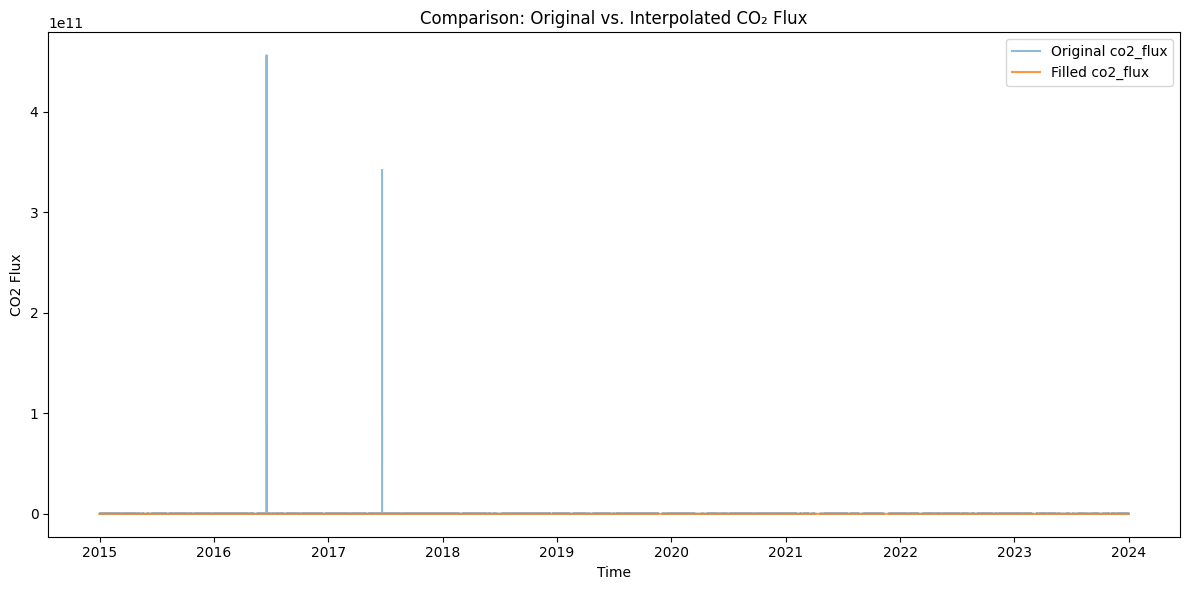


Statistics of filled co2_flux:
count    157776.000000
mean         -0.692909
std           5.520413
min         -14.799859
25%          -4.315462
50%           0.631037
75%           2.911736
max          11.798248
Name: co2_flux_filled, dtype: float64

Remaining missing values in 'co2_flux_filled': 0 (0.00%)


In [4]:
# Set the random seed for reproducibility
np.random.seed(42)

# Assumption: The datasets (air_quality, meteorology, soil, fluxes) are already imported and prepared.

# ---------------------------------
# -1. Ensure complete time index (e.g., 30-minute intervals)
# ---------------------------------
# Create a complete datetime index from min to max timestamp with 30-minute intervals
expected_index = pd.date_range(start=fluxes.index.min(), end=fluxes.index.max(), freq='30T')

# Reindex the flux dataset to include missing timestamps
flux_df = fluxes.reindex(expected_index)

# Keep the index named for compatibility
flux_df.index.name = fluxes.index.name  # In case original index had a name

# ---------------------------------
# 0. Preparation: Interpolation of solar radiation data
# ---------------------------------
# The variable SW_IN_1_1_1 from the meteorology dataset is used for day/night determination.
# Ensure SW_IN_1_1_1 is non-negative (physically not possible otherwise)
meteorology['SW_IN_1_1_1'] = meteorology['SW_IN_1_1_1'].clip(lower=0)
# Interpolate missing values in SW_IN_1_1_1 using time-based interpolation.
meteorology['SW_IN_1_1_1'] = meteorology['SW_IN_1_1_1'].interpolate(method='time', limit_direction='both')

# To align solar radiation data with flux timestamps, reindex the meteorological SW_IN values 
# to match the flux dataset's time grid using the nearest method, as meteorological data is at 1-minute intervals.

flux_df['SW_IN'] = meteorology['SW_IN_1_1_1'].reindex(flux_df.index, method='nearest')

# ---------------------------------
# 1. Statistical analysis and outlier removal of CO₂ flux data
# ---------------------------------
# Copy the original CO₂ flux data into a new column
flux_df['co2_flux_clean'] = flux_df['co2_flux'].copy()

# Set values outside the 95% range (less than -14.8 or greater than 11.8) as outliers to NaN
flux_df.loc[(flux_df['co2_flux_clean'] < -14.8) | (flux_df['co2_flux_clean'] > 11.8), 'co2_flux_clean'] = np.nan

print("Statistics of cleaned co2_flux (outliers removed):")
print(flux_df['co2_flux_clean'].describe())

# ---------------------------------
# 2. Preparation for interpolation: Differentiating between short and long gaps
# ---------------------------------
# Determine the typical sampling interval in hours (median of time differences)
median_interval = flux_df.index.to_series().diff().median().total_seconds() / 3600.0

# Perform an initial linear time interpolation to fill all gaps
flux_df['co2_flux_lin'] = flux_df['co2_flux_clean'].interpolate(method='time', limit_direction='both')

# Identify indices of gaps longer than 1.5 hours
na_mask = flux_df['co2_flux_clean'].isna()
group_ids = (na_mask != na_mask.shift()).cumsum()
missing_groups = flux_df[na_mask].groupby(group_ids)

long_gap_indices = []
for group_id, group in missing_groups:
    # Compute the gap duration (difference between first and last timestamp plus one typical interval)
    gap_duration = (group.index[-1] - group.index[0]).total_seconds() / 3600.0 + median_interval
    if gap_duration > 1.5:
        long_gap_indices.extend(group.index)

# Reset values in the linearly interpolated series to NaN for long gaps
flux_df.loc[long_gap_indices, 'co2_flux_lin'] = np.nan

# ---------------------------------
# 3. Definition of day/night determination using solar radiation
# ---------------------------------
# Daytime is assumed when SW_IN > 0 W/m², otherwise, it is considered nighttime.
def is_day(timestamp):
    # Use the interpolated SW_IN value from the flux dataset for the given timestamp.
    # If the value is missing, default to nighttime.
    sw_value = flux_df.at[timestamp, 'SW_IN'] if pd.notnull(flux_df.at[timestamp, 'SW_IN']) else 0
    return sw_value > 0

# ---------------------------------
# 4. Enhanced Gap Filling using Marginal Distribution Sampling (MDS) with Flexible Conditions
# ---------------------------------
# For each timestamp in long gaps, attempt to sample from relevant CO₂ flux data distributions.

for ts in long_gap_indices:
    sw_value = flux_df.at[ts, 'SW_IN'] if pd.notnull(flux_df.at[ts, 'SW_IN']) else 0

    if sw_value > 0:
        # Daytime: First, try strict criteria (SW_IN > 0)
        pool = flux_df.loc[flux_df['SW_IN'] > 0, 'co2_flux_clean'].dropna()

        if len(pool) == 0:
            # If no data matches, fall back to similar hour across the dataset
            similar_hour = flux_df.index.hour == ts.hour
            pool = flux_df.loc[similar_hour, 'co2_flux_clean'].dropna()
    else:
        # Nighttime: First, try strict criteria (SW_IN <= 0)
        pool = flux_df.loc[flux_df['SW_IN'] <= 0, 'co2_flux_clean'].dropna()

        if len(pool) == 0:
            # If no data matches, fall back to similar hour
            similar_hour = flux_df.index.hour == ts.hour
            pool = flux_df.loc[similar_hour, 'co2_flux_clean'].dropna()

    if len(pool) > 0:
        # Fill using random sample from the pool
        flux_df.at[ts, 'co2_flux_lin'] = np.random.choice(pool.values)
    else:
        # Final fallback: Use the mean of nearby valid values within ±7 days
        window = pd.Timedelta(days=7)
        nearby = flux_df['co2_flux_clean'].loc[ts - window : ts + window].dropna()

        if len(nearby) > 0:
            flux_df.at[ts, 'co2_flux_lin'] = nearby.mean()
        else:
            flux_df.at[ts, 'co2_flux_lin'] = np.nan

# Store the result in the final filled column
flux_df['co2_flux_filled'] = flux_df['co2_flux_lin']
# ---------------------------------
# 5. Interpolation of external variables in the flux dataset
# ---------------------------------
# Perform a simple time interpolation for all other variables with missing values.
cols_to_exclude = ['co2_flux', 'co2_flux_clean', 'co2_flux_lin', 'co2_flux_filled', 'SW_IN']
external_cols = [col for col in flux_df.columns if col not in cols_to_exclude]

if external_cols:
    flux_df[external_cols] = flux_df[external_cols].interpolate(method='time', limit_direction='both')

# ---------------------------------
# 6. Visualization and final statistics
# ---------------------------------
plt.figure(figsize=(12, 6))
plt.plot(flux_df.index, flux_df['co2_flux'], label='Original co2_flux', alpha=0.5)
plt.plot(flux_df.index, flux_df['co2_flux_filled'], label='Filled co2_flux', alpha=0.8)
plt.xlabel("Time")
plt.ylabel("CO2 Flux")
plt.title("Comparison: Original vs. Interpolated CO₂ Flux")
plt.legend()
plt.tight_layout()
plt.show()

print("\nStatistics of filled co2_flux:")
print(flux_df['co2_flux_filled'].describe())
# ---------------------------------
# Report remaining missing values
# ---------------------------------
remaining_gaps = flux_df['co2_flux_filled'].isna().sum()
total_points = len(flux_df)
percent_missing = (remaining_gaps / total_points) * 100

print(f"\nRemaining missing values in 'co2_flux_filled': {remaining_gaps} ({percent_missing:.2f}%)")


In [5]:
def fill_gaps_mds(df, col_original, condition_pool_func, gap_threshold_hours=1.5):
    """
    Fills gaps in a time series based on linear interpolation and MDS for long gaps.
    Adds final fallback interpolation to ensure no missing values remain.
    """
    missing_before = df[col_original].isna().sum()
    print(f"{col_original}: Missing values before interpolation: {missing_before}")
    
    col_lin = col_original + '_lin'
    col_filled = col_original + '_filled'
    df[col_lin] = df[col_original].interpolate(method='time', limit_direction='both')
    
    missing_after_lin = df[col_lin].isna().sum()
    print(f"{col_original}: Missing values after linear interpolation: {missing_after_lin}")
    
    na_mask = df[col_original].isna()
    group_ids = (na_mask != na_mask.shift()).cumsum()
    missing_groups = df[na_mask].groupby(group_ids)
    
    median_interval = df.index.to_series().diff().median().total_seconds() / 3600.0
    long_gap_indices = []
    for group_id, group in missing_groups:
        gap_duration = (group.index[-1] - group.index[0]).total_seconds() / 3600.0 + median_interval
        if gap_duration > gap_threshold_hours:
            long_gap_indices.extend(group.index)
    
    print(f"{col_original}: Number of long gaps to fill with MDS: {len(long_gap_indices)}")
    
    df.loc[long_gap_indices, col_lin] = np.nan
    
    for ts in long_gap_indices:
        pool = condition_pool_func(df, ts, col_original)
        if len(pool) > 0:
            df.at[ts, col_lin] = np.random.choice(pool.values)
        else:
            df.at[ts, col_lin] = np.nan
    
    missing_after_mds = df[col_lin].isna().sum()
    print(f"{col_original}: Missing values after MDS: {missing_after_mds}")
    
    df[col_filled] = df[col_lin]

    # Final fallback: simple interpolation if still NaNs remain
    if df[col_filled].isnull().any():
        print(f"{col_filled} still has missing values after MDS. Applying final fallback interpolation...")
        df[col_filled] = df[col_filled].interpolate(method='time', limit_direction='both')
    
    missing_after = df[col_filled].isnull().sum()
    print(f"{col_filled}: Missing values after final interpolation: {missing_after}")
    
    return df

def meteo_pool(df, ts, col_original):
    current_hour = ts.hour
    pool = df[df.index.hour == current_hour][col_original].dropna()
    if pool.empty:
        pool = df[col_original].dropna()
    return pool

# Determine the relevant datasets for interpolation
meteorology = meteorology if 'meteorology' in locals() else None
soil = soil if 'soil' in locals() else None
flux_df = flux_df if 'flux_df' in locals() else None

print("\n=== STARTING GAP FILLING PROCESS ===")
print(f"Available datasets: {[name for name, ds in {'meteorology': meteorology, 'soil': soil}.items() if ds is not None]}")

datasets = {'meteorology': meteorology,
            'soil': soil,
            }

# Ensure all datasets share the same index as flux_df
for name in datasets:
    if datasets[name] is not None:
        datasets[name] = datasets[name].reindex(flux_df.index)

# Apply interpolation to relevant variables and add them to flux_df
for dataset_name, dataset in datasets.items():
    if dataset is not None:
        print(f"\nProcessing {dataset_name} dataset...")
        if dataset_name == 'meteorology':
            target_cols = ['TA_1_1_1', 'RH_1_1_1', 'WS_1_1_1', 'SW_IN']
        elif dataset_name == 'soil':
            target_cols = ['TS_1_1_1']
        else:
            target_cols = []
        
        print(f"Target columns in {dataset_name}: {target_cols}")
        for col in target_cols:
            if col in dataset.columns:
                print(f"\n--- Processing {col} ---")
                dataset = fill_gaps_mds(dataset, col, meteo_pool, gap_threshold_hours=1.5)
                datasets[dataset_name] = dataset  # Update the dataset
                
                # Add interpolated values directly (same time index, no reindexing needed)
                flux_df[col] = dataset[col + '_filled']
                print(f"Added interpolated {col} to flux_df")

print("\n=== GAP FILLING COMPLETE ===")

# Assemble the feature set
features = ['SW_IN', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'is_day',
            'co2_flux_lag1', 'co2_flux_lag24', 'co2_flux_rolling_mean_6h', 'co2_flux_rolling_mean_24h']
if 'TA_1_1_1' in flux_df.columns:
    features.extend(['TA_1_1_1', 'temp_radiation_interaction'])
if 'RH_1_1_1' in flux_df.columns:
    features.append('RH_1_1_1')
if 'WS_1_1_1' in flux_df.columns:
    features.append('WS_1_1_1')
if 'TS_1_1_1' in flux_df.columns:
    features.append('TS_1_1_1')
print(f"Final feature list: {features}")

# Print summary of missing values in flux_df features
print("\n=== FINAL MISSING VALUES SUMMARY ===")
for feature in features:
    if feature in flux_df.columns:
        missing = flux_df[feature].isna().sum()
        percent_missing = 100 * missing / len(flux_df)
        print(f"{feature}: {missing} missing values ({percent_missing:.2f}%)")


=== STARTING GAP FILLING PROCESS ===
Available datasets: ['meteorology', 'soil']

Processing meteorology dataset...
Target columns in meteorology: ['TA_1_1_1', 'RH_1_1_1', 'WS_1_1_1', 'SW_IN']

--- Processing TA_1_1_1 ---
TA_1_1_1: Missing values before interpolation: 429
TA_1_1_1: Missing values after linear interpolation: 0
TA_1_1_1: Number of long gaps to fill with MDS: 426
TA_1_1_1: Missing values after MDS: 0
TA_1_1_1_filled: Missing values after final interpolation: 0
Added interpolated TA_1_1_1 to flux_df

--- Processing RH_1_1_1 ---
RH_1_1_1: Missing values before interpolation: 431
RH_1_1_1: Missing values after linear interpolation: 0
RH_1_1_1: Number of long gaps to fill with MDS: 426
RH_1_1_1: Missing values after MDS: 0
RH_1_1_1_filled: Missing values after final interpolation: 0
Added interpolated RH_1_1_1 to flux_df

--- Processing WS_1_1_1 ---
WS_1_1_1: Missing values before interpolation: 450
WS_1_1_1: Missing values after linear interpolation: 0
WS_1_1_1: Number of l

## Data Visualization
The data is being visualized using histograms, boxplots, density distributions, Q-Q plots, and rolling statistics.
This helps to understand the data and the quality of the data and the previous interpolation.


=== SW_IN Analysis ===
Descriptive Statistics for SW_IN:
count    157776.000000
mean        124.545383
std         214.545357
min         -12.731000
25%          -2.543000
50%           1.214000
75%         166.375250
max        1156.520000
Name: SW_IN, dtype: float64

Fraction of time points classified as 'day' (SW_IN > 20): 44.37%


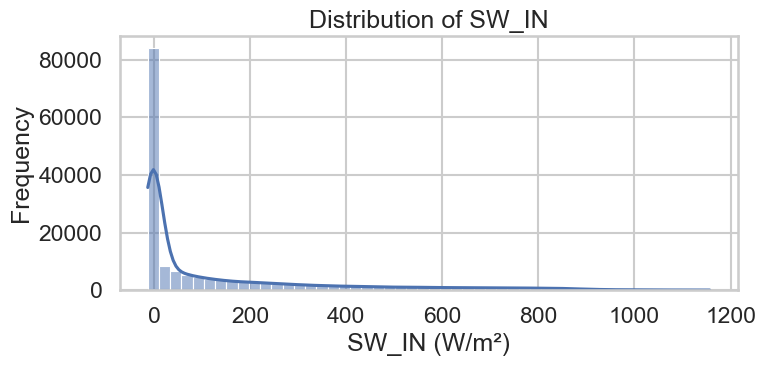

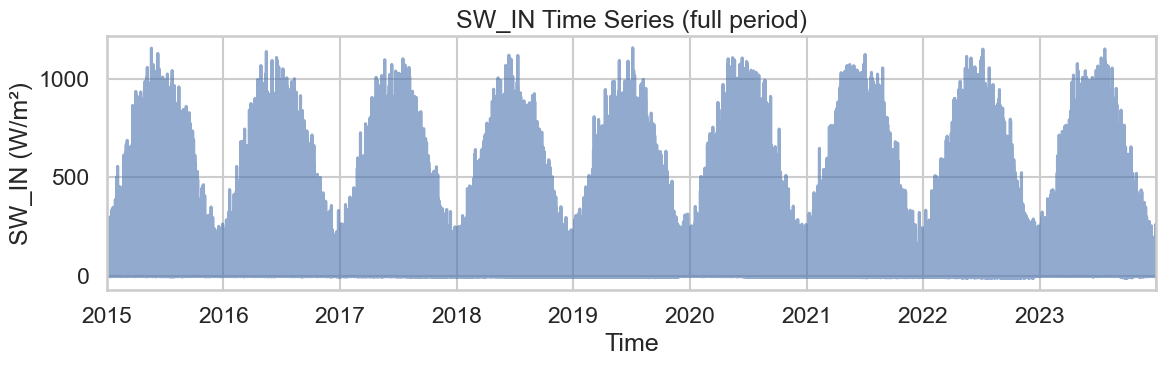

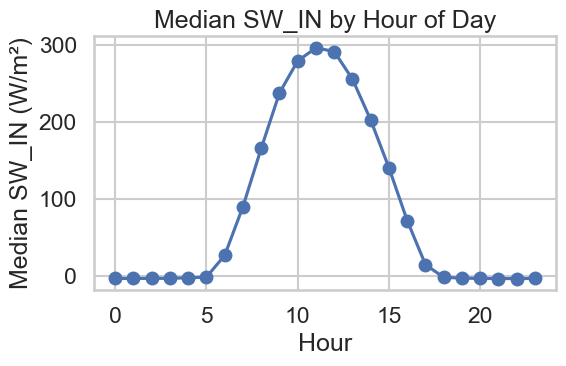

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== SW_IN Analysis ===")

# 1. Grundstatistik
sw_series = flux_df['SW_IN']
print("Descriptive Statistics for SW_IN:")
print(sw_series.describe())

# 2. Anteil an Zeitpunkten mit SW_IN > 20 (für Tag/Nacht-Grenze)
is_day = sw_series > 20
day_fraction = is_day.mean()
print(f"\nFraction of time points classified as 'day' (SW_IN > 20): {day_fraction:.2%}")

# 3. Tagesprofil analysieren (Median SW_IN je Stunde)
hourly_profile = sw_series.groupby(sw_series.index.hour).median()

# 4. Plots

# Histogramm
plt.figure(figsize=(8, 4))
sns.histplot(sw_series, bins=50, kde=True)
plt.title("Distribution of SW_IN")
plt.xlabel("SW_IN (W/m²)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Zeitverlauf (Teilansicht)
plt.figure(figsize=(12, 4))
flux_df['SW_IN'].plot(alpha=0.6)
plt.title("SW_IN Time Series (full period)")
plt.xlabel("Time")
plt.ylabel("SW_IN (W/m²)")
plt.tight_layout()
plt.show()

# Tagesmittel (Median nach Stunde)
plt.figure(figsize=(6, 4))
hourly_profile.plot(marker='o')
plt.title("Median SW_IN by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Median SW_IN (W/m²)")
plt.grid(True)
plt.tight_layout()
plt.show()

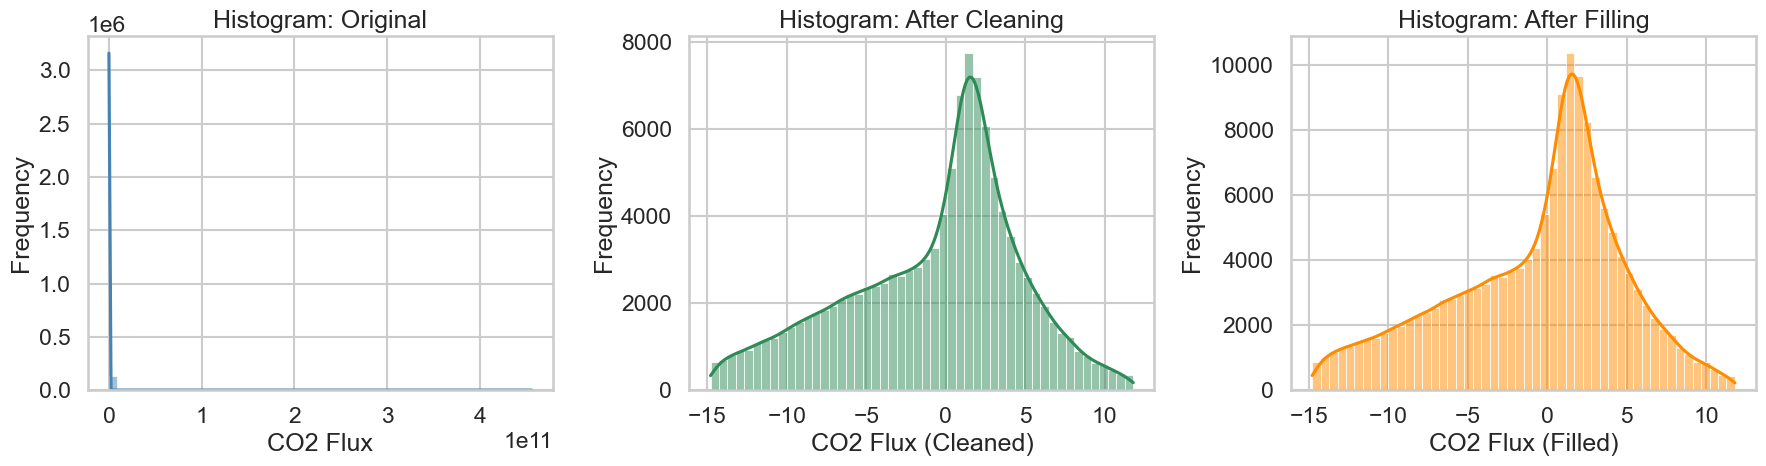

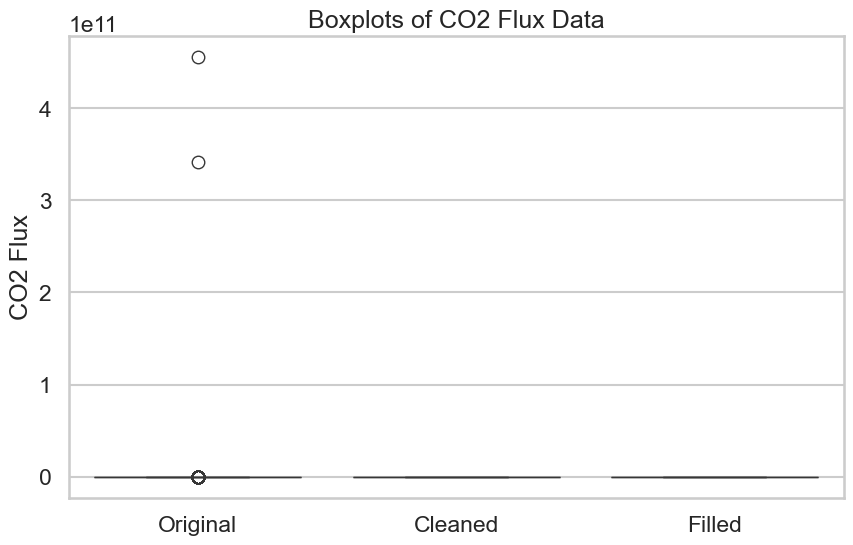

/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_2319/4284245319.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flux_df['co2_flux'].dropna(), label="Original", shade=True, color="steelblue")
/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_2319/4284245319.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flux_df['co2_flux_clean'].dropna(), label="Cleaned", shade=True, color="seagreen")
/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_2319/4284245319.py:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(flux_df['co2_flux_filled'].dropna(), label="Filled", shade=True, color="darkorange

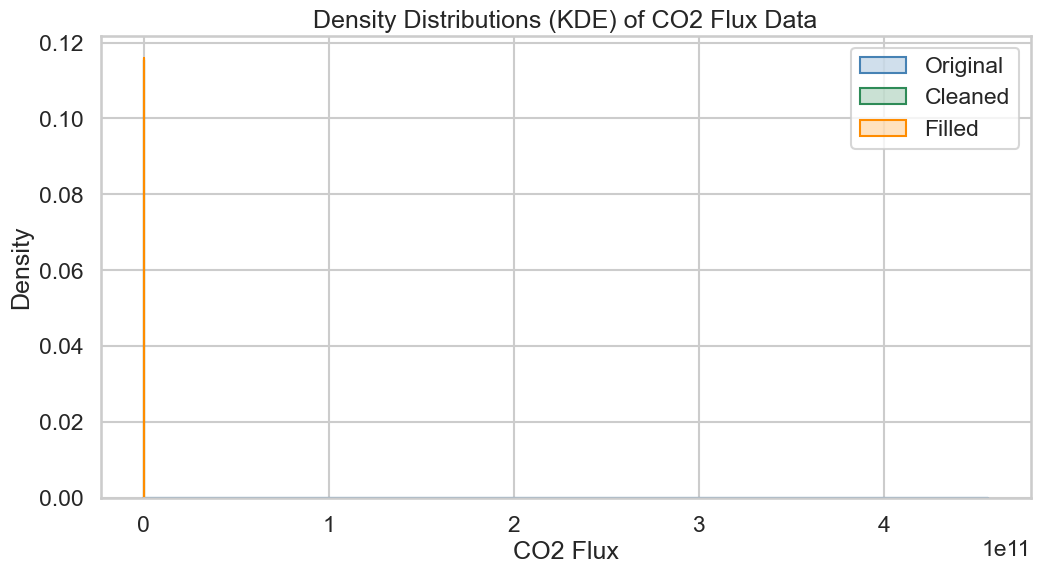

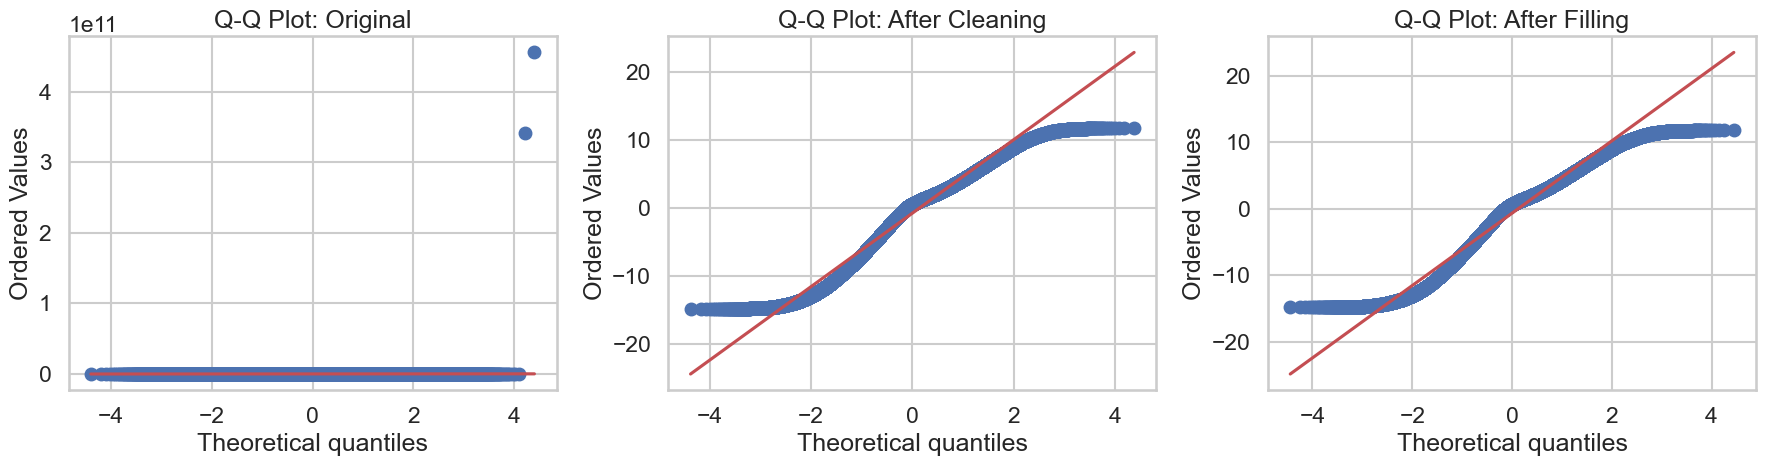

In [98]:


# Set a style for the plots
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({'figure.max_open_warning': 0})

# Assumption: flux_df is already available and contains the following columns:
# - 'co2_flux': Original data
# - 'co2_flux_clean': After outlier removal (values outside [-14.8, 11.8] were removed)
# - 'co2_flux_filled': After interpolation (linear interpolation for short gaps and MDS for long gaps)

# ---------------------------------
# 1. Histograms with KDE (Density Curves)
# ---------------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(flux_df['co2_flux'], bins=50, kde=True, color="steelblue")
plt.title("Histogram: Original")
plt.xlabel("CO2 Flux")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
sns.histplot(flux_df['co2_flux_clean'], bins=50, kde=True, color="seagreen")
plt.title("Histogram: After Cleaning")
plt.xlabel("CO2 Flux (Cleaned)")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
sns.histplot(flux_df['co2_flux_filled'], bins=50, kde=True, color="darkorange")
plt.title("Histogram: After Filling")
plt.xlabel("CO2 Flux (Filled)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# ---------------------------------
# 2. Boxplots to Compare Distributions
# ---------------------------------
# Create a DataFrame containing the three versions for easier boxplot visualization.
df_box = pd.DataFrame({
    "Original": flux_df['co2_flux'],
    "Cleaned": flux_df['co2_flux_clean'],
    "Filled": flux_df['co2_flux_filled']
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_box, palette=["steelblue", "seagreen", "darkorange"])
plt.title("Boxplots of CO2 Flux Data")
plt.ylabel("CO2 Flux")
plt.show()

# ---------------------------------
# 3. Density Distributions (KDE) Comparison
# ---------------------------------
plt.figure(figsize=(12, 6))
sns.kdeplot(flux_df['co2_flux'].dropna(), label="Original", shade=True, color="steelblue")
sns.kdeplot(flux_df['co2_flux_clean'].dropna(), label="Cleaned", shade=True, color="seagreen")
sns.kdeplot(flux_df['co2_flux_filled'].dropna(), label="Filled", shade=True, color="darkorange")
plt.title("Density Distributions (KDE) of CO2 Flux Data")
plt.xlabel("CO2 Flux")
plt.ylabel("Density")
plt.legend()
plt.show()

# ---------------------------------
# 4. Q-Q Plots to Check Normality Assumption
# ---------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Q-Q Plot for Original Data
stats.probplot(flux_df['co2_flux'].dropna(), dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot: Original")

# Q-Q Plot for Cleaned Data
stats.probplot(flux_df['co2_flux_clean'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot: After Cleaning")

# Q-Q Plot for Filled Data
stats.probplot(flux_df['co2_flux_filled'].dropna(), dist="norm", plot=axes[2])
axes[2].set_title("Q-Q Plot: After Filling")

plt.tight_layout()
plt.show()

This Rolling Statistics Analysis helps to understand the data and the quality of the data and the previous interpolation.

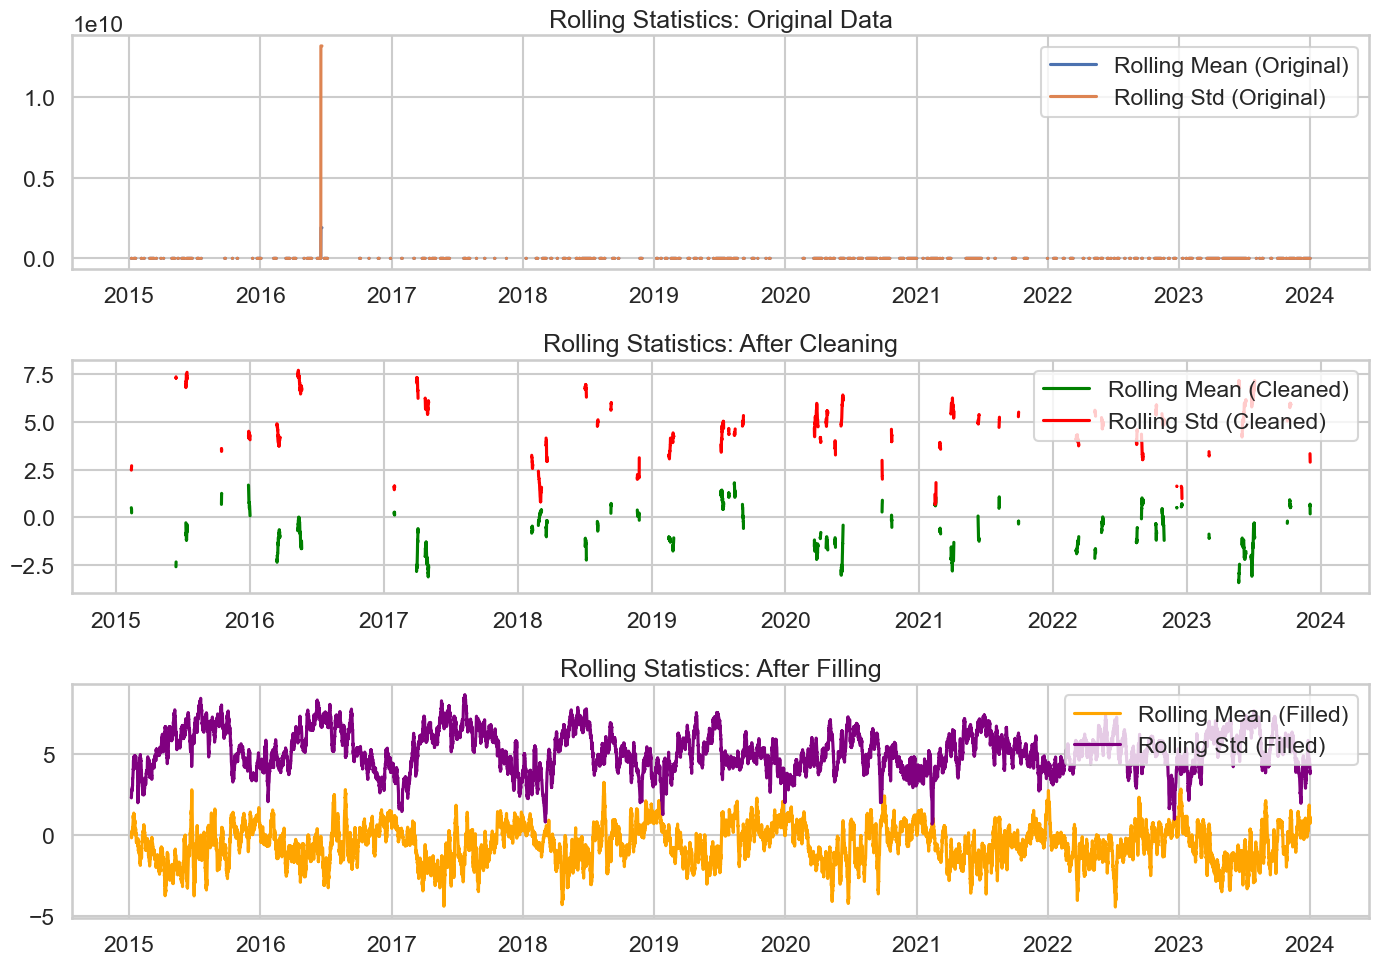

In [17]:
# ---------------------------------
# 5. Rolling Statistics Analysis
# ---------------------------------
# Define the rolling window size (e.g., 48 steps for 30-minute data ~ 24 hours)
window_size = 48

# Compute rolling mean and standard deviation for original, cleaned, and filled datasets
flux_df['roll_mean_orig'] = flux_df['co2_flux'].rolling(window=window_size).mean()
flux_df['roll_std_orig'] = flux_df['co2_flux'].rolling(window=window_size).std()

flux_df['roll_mean_clean'] = flux_df['co2_flux_clean'].rolling(window=window_size).mean()
flux_df['roll_std_clean'] = flux_df['co2_flux_clean'].rolling(window=window_size).std()

flux_df['roll_mean_filled'] = flux_df['co2_flux_filled'].rolling(window=window_size).mean()
flux_df['roll_std_filled'] = flux_df['co2_flux_filled'].rolling(window=window_size).std()

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(flux_df.index, flux_df['roll_mean_orig'], label='Rolling Mean (Original)')
plt.plot(flux_df.index, flux_df['roll_std_orig'], label='Rolling Std (Original)')
plt.title("Rolling Statistics: Original Data")
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
plt.plot(flux_df.index, flux_df['roll_mean_clean'], label='Rolling Mean (Cleaned)', color='green')
plt.plot(flux_df.index, flux_df['roll_std_clean'], label='Rolling Std (Cleaned)', color='red')
plt.title("Rolling Statistics: After Cleaning")
plt.legend(loc='upper right')

plt.subplot(3, 1, 3)
plt.plot(flux_df.index, flux_df['roll_mean_filled'], label='Rolling Mean (Filled)', color='orange')
plt.plot(flux_df.index, flux_df['roll_std_filled'], label='Rolling Std (Filled)', color='purple')
plt.title("Rolling Statistics: After Filling")
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

This ACF and PACF Analysis is important for SARIMAX model, because it helps to understand if the data is stationary.
If the data is not stationary, the model will not be able to predict the data.


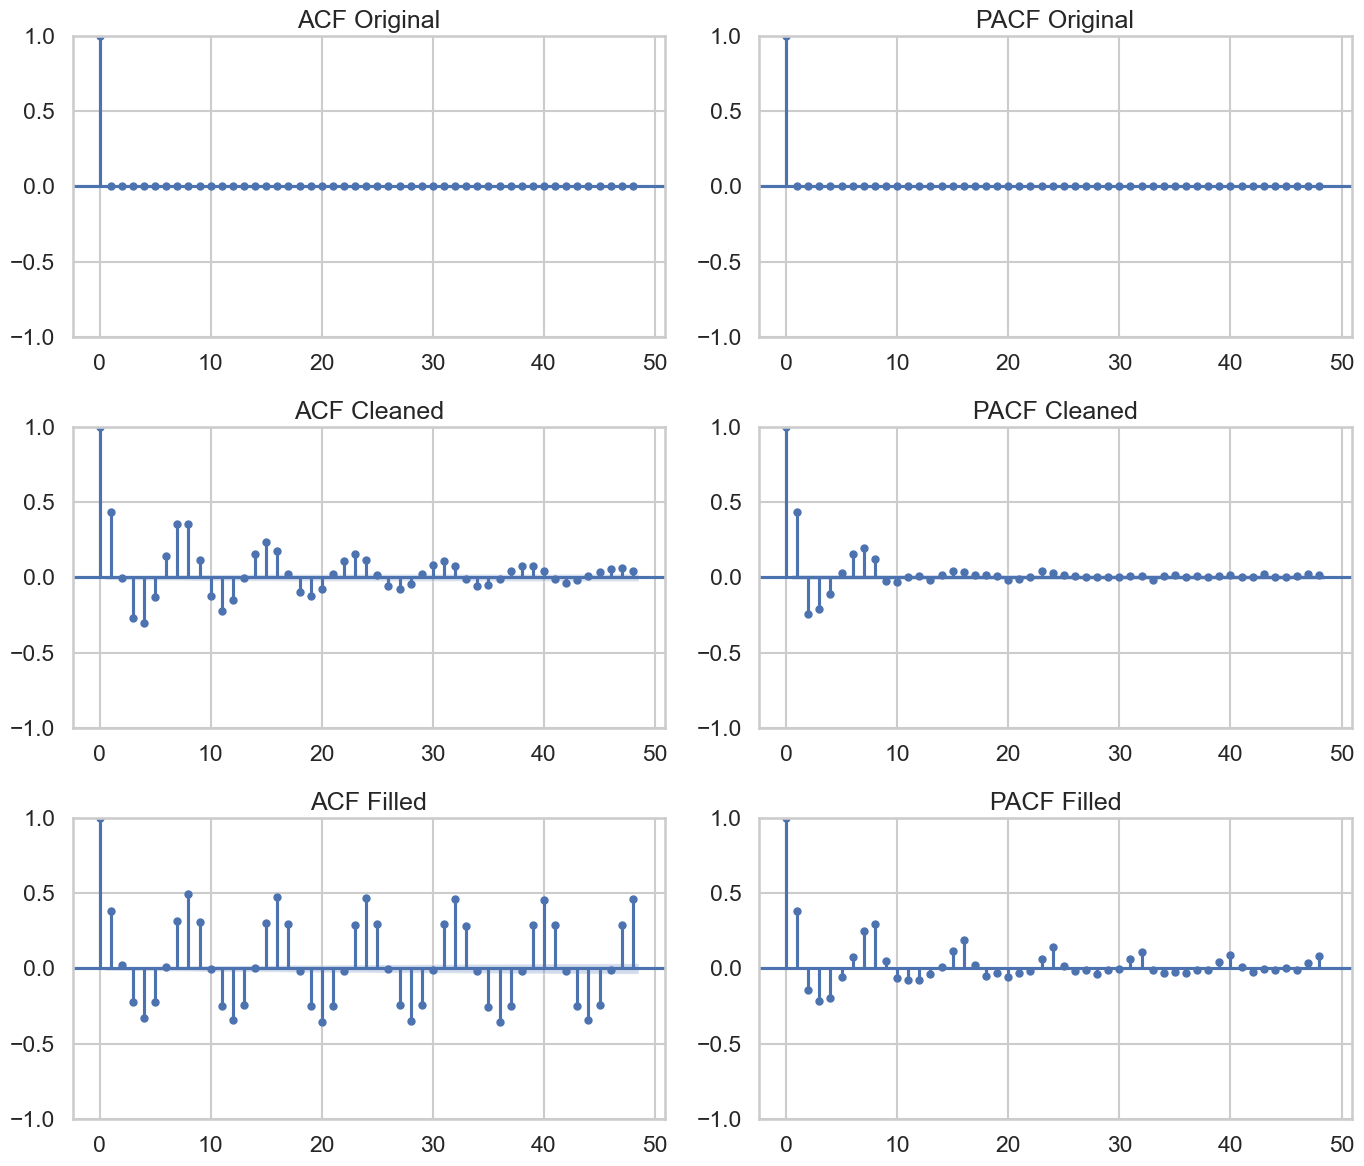

In [18]:


# Create a figure with subplots for ACF and PACF plots across different data versions
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Original data: Analyze autocorrelation and partial autocorrelation
sm.graphics.tsa.plot_acf(flux_df['co2_flux'].dropna(), lags=48, ax=axes[0, 0], title='ACF Original')
sm.graphics.tsa.plot_pacf(flux_df['co2_flux'].dropna(), lags=48, ax=axes[0, 1], title='PACF Original')

# Cleaned data: Assess the impact of outlier removal on autocorrelation structure
sm.graphics.tsa.plot_acf(flux_df['co2_flux_clean'].dropna(), lags=48, ax=axes[1, 0], title='ACF Cleaned')
sm.graphics.tsa.plot_pacf(flux_df['co2_flux_clean'].dropna(), lags=48, ax=axes[1, 1], title='PACF Cleaned')

# Filled data: Examine the influence of interpolation on temporal dependencies
sm.graphics.tsa.plot_acf(flux_df['co2_flux_filled'].dropna(), lags=48, ax=axes[2, 0], title='ACF Filled')
sm.graphics.tsa.plot_pacf(flux_df['co2_flux_filled'].dropna(), lags=48, ax=axes[2, 1], title='PACF Filled')

# Optimize layout for better readability
plt.tight_layout()
plt.show()

Testing for ADF and KPSS tests is important for SARIMAX model, because it helps to understand if the data is stationary.
If the data is not stationary, the model will not be able to predict the data.




Analysis for Daily (Period=48)



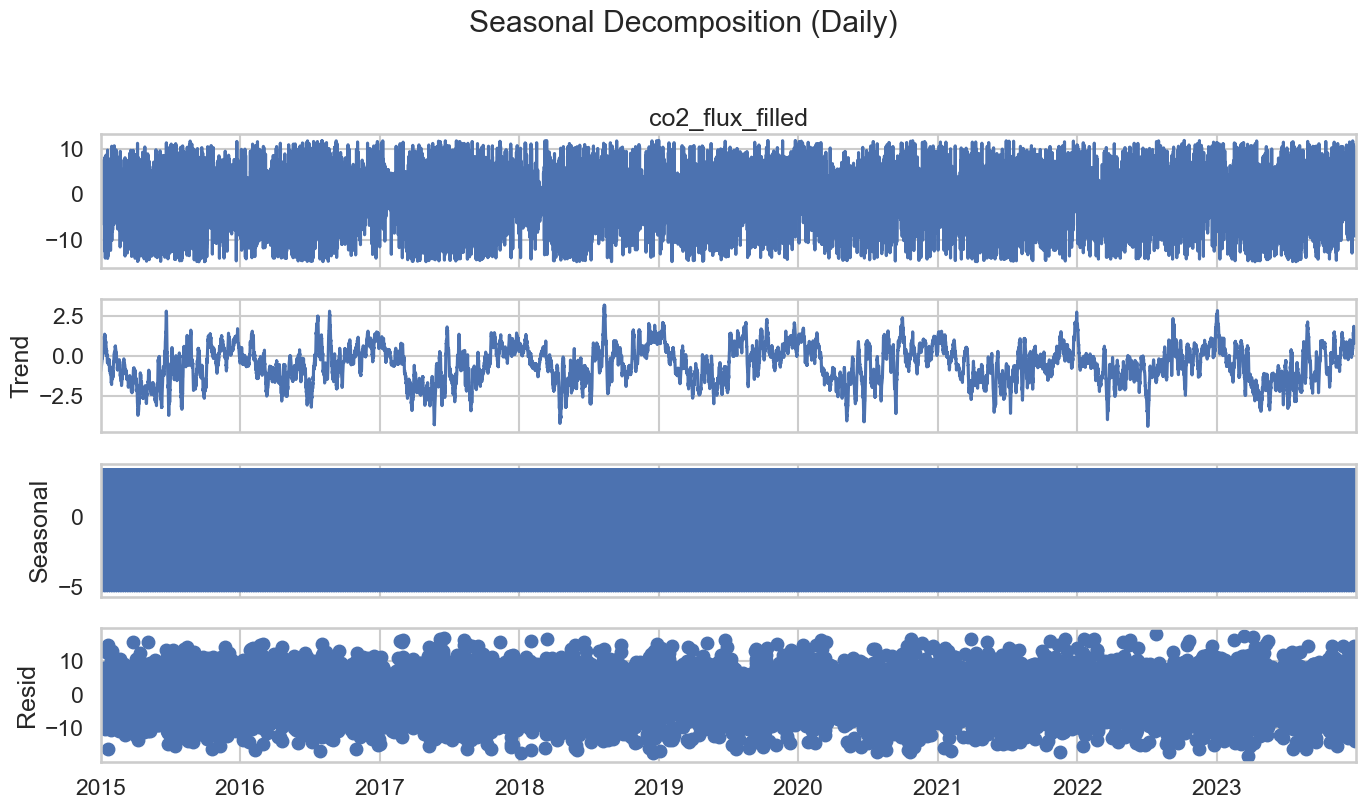


=== ADF: Daily - Original Series ===
  Test Statistic: -15.667739491371242
  p-Value: 1.5261147325122681e-28
  # Lags: 49
  # Observations: 26246
  Critical Value 1%: -3.431
  Critical Value 5%: -2.862
  Critical Value 10%: -2.567
  => Stationary (Null hypothesis rejected, p<0.05)

=== KPSS: Daily - Original Series ===
  Test Statistic: 0.21033151731786953
  p-Value: 0.1
  # Lags: 99
  Critical Value 10%: 0.347
  Critical Value 5%: 0.463
  Critical Value 2.5%: 0.574
  Critical Value 1%: 0.739
  => Stationary (Null hypothesis not rejected, p>=0.05)

=== ADF: Daily - Residuals ===


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_59166/1955337022.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


  Test Statistic: -40.326377405861855
  p-Value: 0.0
  # Lags: 49
  # Observations: 26246
  Critical Value 1%: -3.431
  Critical Value 5%: -2.862
  Critical Value 10%: -2.567
  => Stationary (Null hypothesis rejected, p<0.05)

=== KPSS: Daily - Residuals ===
  Test Statistic: 0.0024895008285840702
  p-Value: 0.1
  # Lags: 31
  Critical Value 10%: 0.347
  Critical Value 5%: 0.463
  Critical Value 2.5%: 0.574
  Critical Value 1%: 0.739
  => Stationary (Null hypothesis not rejected, p>=0.05)


Analysis for Weekly (Period=336)



/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_59166/1955337022.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


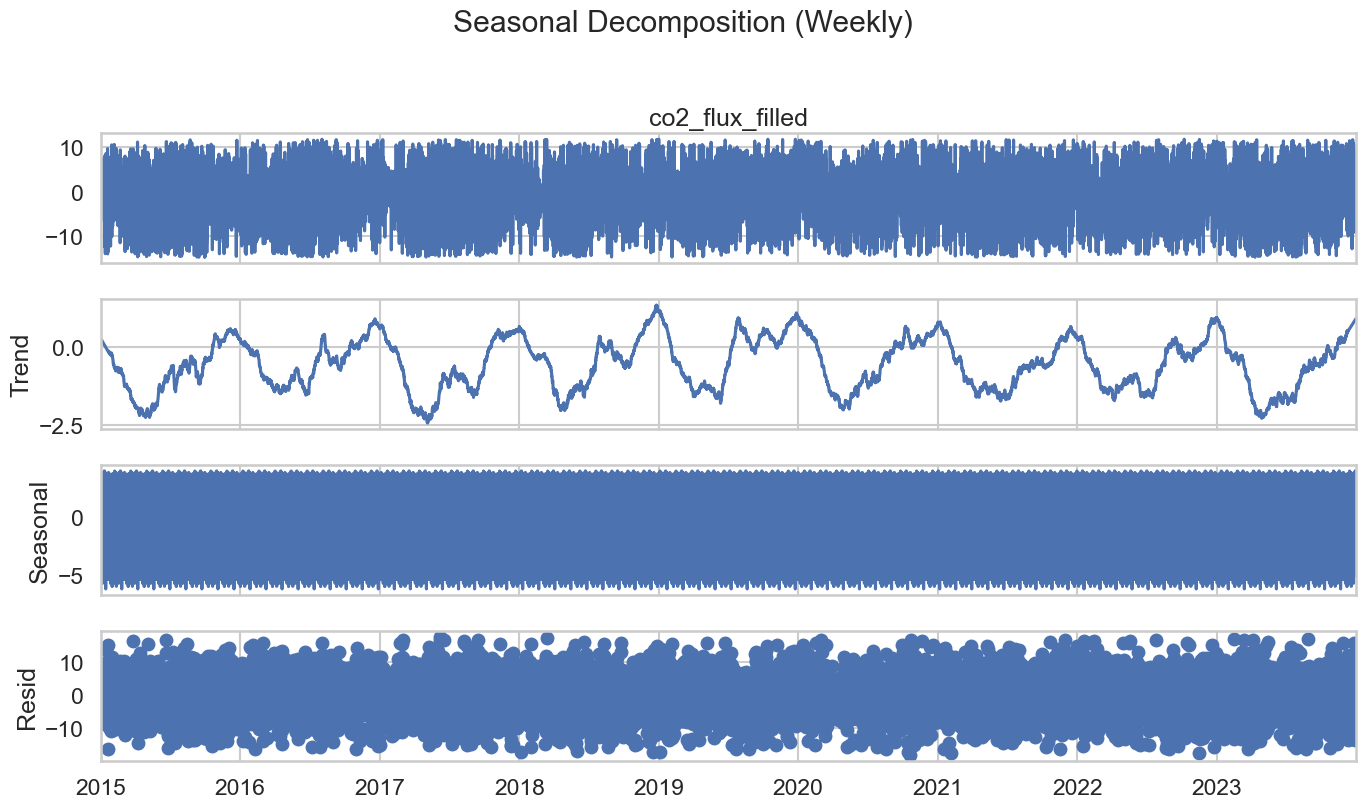


=== ADF: Weekly - Original Series ===
  Test Statistic: -15.667739491371242
  p-Value: 1.5261147325122681e-28
  # Lags: 49
  # Observations: 26246
  Critical Value 1%: -3.431
  Critical Value 5%: -2.862
  Critical Value 10%: -2.567
  => Stationary (Null hypothesis rejected, p<0.05)

=== KPSS: Weekly - Original Series ===
  Test Statistic: 0.21033151731786953
  p-Value: 0.1
  # Lags: 99
  Critical Value 10%: 0.347
  Critical Value 5%: 0.463
  Critical Value 2.5%: 0.574
  Critical Value 1%: 0.739
  => Stationary (Null hypothesis not rejected, p>=0.05)

=== ADF: Weekly - Residuals ===


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_59166/1955337022.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


  Test Statistic: -23.615819681276964
  p-Value: 0.0
  # Lags: 49
  # Observations: 26246
  Critical Value 1%: -3.431
  Critical Value 5%: -2.862
  Critical Value 10%: -2.567
  => Stationary (Null hypothesis rejected, p<0.05)

=== KPSS: Weekly - Residuals ===
  Test Statistic: 0.001676646486654105
  p-Value: 0.1
  # Lags: 64
  Critical Value 10%: 0.347
  Critical Value 5%: 0.463
  Critical Value 2.5%: 0.574
  Critical Value 1%: 0.739
  => Stationary (Null hypothesis not rejected, p>=0.05)


Analysis for Monthly (Period=1440)



/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_59166/1955337022.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


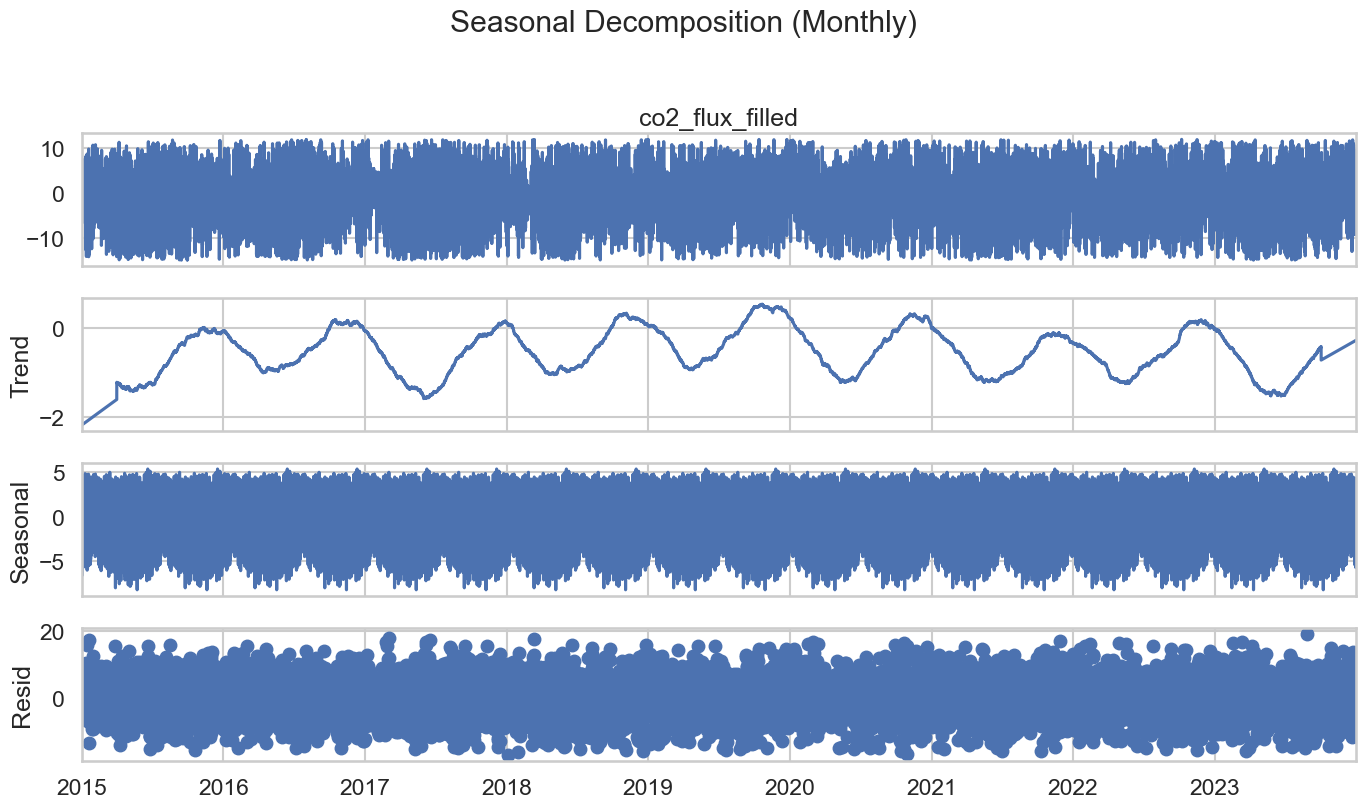


=== ADF: Monthly - Original Series ===
  Test Statistic: -15.667739491371242
  p-Value: 1.5261147325122681e-28
  # Lags: 49
  # Observations: 26246
  Critical Value 1%: -3.431
  Critical Value 5%: -2.862
  Critical Value 10%: -2.567
  => Stationary (Null hypothesis rejected, p<0.05)

=== KPSS: Monthly - Original Series ===
  Test Statistic: 0.21033151731786953
  p-Value: 0.1
  # Lags: 99
  Critical Value 10%: 0.347
  Critical Value 5%: 0.463
  Critical Value 2.5%: 0.574
  Critical Value 1%: 0.739
  => Stationary (Null hypothesis not rejected, p>=0.05)

=== ADF: Monthly - Residuals ===


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_59166/1955337022.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


  Test Statistic: -19.946003991177562
  p-Value: 0.0
  # Lags: 49
  # Observations: 26246
  Critical Value 1%: -3.431
  Critical Value 5%: -2.862
  Critical Value 10%: -2.567
  => Stationary (Null hypothesis rejected, p<0.05)

=== KPSS: Monthly - Residuals ===
  Test Statistic: 0.09649236929784917
  p-Value: 0.1
  # Lags: 67
  Critical Value 10%: 0.347
  Critical Value 5%: 0.463
  Critical Value 2.5%: 0.574
  Critical Value 1%: 0.739
  => Stationary (Null hypothesis not rejected, p>=0.05)


Analysis for Yearly (Period=17520)

Error or too few data points for period 17520: x must have 2 complete cycles requires 35040 observations. x only has 26296 observation(s)


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_59166/1955337022.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression=regression, nlags="auto")


In [19]:
# -----------------------------------------------------
# Helper functions for ADF and KPSS tests
# -----------------------------------------------------

def adf_test(series, title="ADF Test"):
    """
    Performs the Augmented Dickey-Fuller test and outputs the results.
    """
    print(f"\n=== {title} ===")
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['Test Statistic', 'p-Value', '# Lags', '# Observations']
    out = dict(zip(labels, result[0:4]))
    
    for key, val in out.items():
        print(f"  {key}: {val}")
    
    # Critical values
    for k, v in result[4].items():
        print(f"  Critical Value {k}: {v:.3f}")
    
    if out['p-Value'] < 0.05:
        print("  => Stationary (Null hypothesis rejected, p<0.05)")
    else:
        print("  => Non-stationary (Null hypothesis not rejected, p>=0.05)")

def kpss_test(series, title="KPSS Test", regression='c'):
    """
    Performs the KPSS test and outputs the results.
    regression='c' tests for level stationarity (constant mean);
    regression='ct' tests for trend stationarity.
    """
    print(f"\n=== {title} ===")
    result = kpss(series.dropna(), regression=regression, nlags="auto")
    labels = ['Test Statistic', 'p-Value', '# Lags']
    out = dict(zip(labels, result[0:3]))
    
    for key, val in out.items():
        print(f"  {key}: {val}")
    
    # Critical values
    for k, v in result[3].items():
        print(f"  Critical Value {k}: {v}")
    
    # Interpretation
    if out['p-Value'] < 0.05:
        print("  => Non-stationary (Null hypothesis rejected, p<0.05)")
    else:
        print("  => Stationary (Null hypothesis not rejected, p>=0.05)")

# -----------------------------------------------------
# Main code: Testing different time series periods
# -----------------------------------------------------

# Example: Assume we have 30-minute interval data in flux_df['co2_flux_filled']
# (already cleaned and filled). If you want to test original data,
# simply select the corresponding column.
time_series = flux_df['co2_flux_filled'].dropna()

# Define different periods (in "number of data points per cycle")
periods = {
    "Daily": 48,          # 30-minute data => 48 per day
    "Weekly": 336,        # 48 * 7
    "Monthly": 1440,      # 48 * 30 (simplified)
    "Yearly": 17520       # 48 * 365 (simplified)
}

for period_name, period_val in periods.items():
    print(f"\n\n{'='*50}")
    print(f"Analysis for {period_name} (Period={period_val})")
    print(f"{'='*50}\n")
    
    # 1) Seasonal decomposition
    # Note: If there is not enough data for such a long period,
    # seasonal_decompose might fail or raise warnings.
    try:
        decomposition = seasonal_decompose(time_series, period=period_val, model='additive', extrapolate_trend='freq')
        
        # Plot
        fig = decomposition.plot()
        fig.suptitle(f"Seasonal Decomposition ({period_name})", y=1.02)
        fig.set_size_inches(14,8)
        plt.tight_layout()
        plt.show()
        
        # Optionally extract residuals and trend
        resid = decomposition.resid
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        
        # 2) Stationarity tests on the original time series (i.e., 'time_series')
        adf_test(time_series, title=f"ADF: {period_name} - Original Series")
        kpss_test(time_series, title=f"KPSS: {period_name} - Original Series", regression='c')
        
        # 3) Stationarity tests on the residuals (if available)
        #    => Residuals should be stationary if seasonality and trend are well captured
        adf_test(resid, title=f"ADF: {period_name} - Residuals")
        kpss_test(resid, title=f"KPSS: {period_name} - Residuals", regression='c')
        
    except ValueError as e:
        print(f"Error or too few data points for period {period_val}: {e}")
    except Exception as e:
        print(f"General error during decomposition for period {period_val}: {e}")

Visualize the seasonality of the data.

/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_59166/983283932.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([monthly.get_group(i) for i in range(1, 13)],
/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_59166/983283932.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_means = df.resample('M').mean()


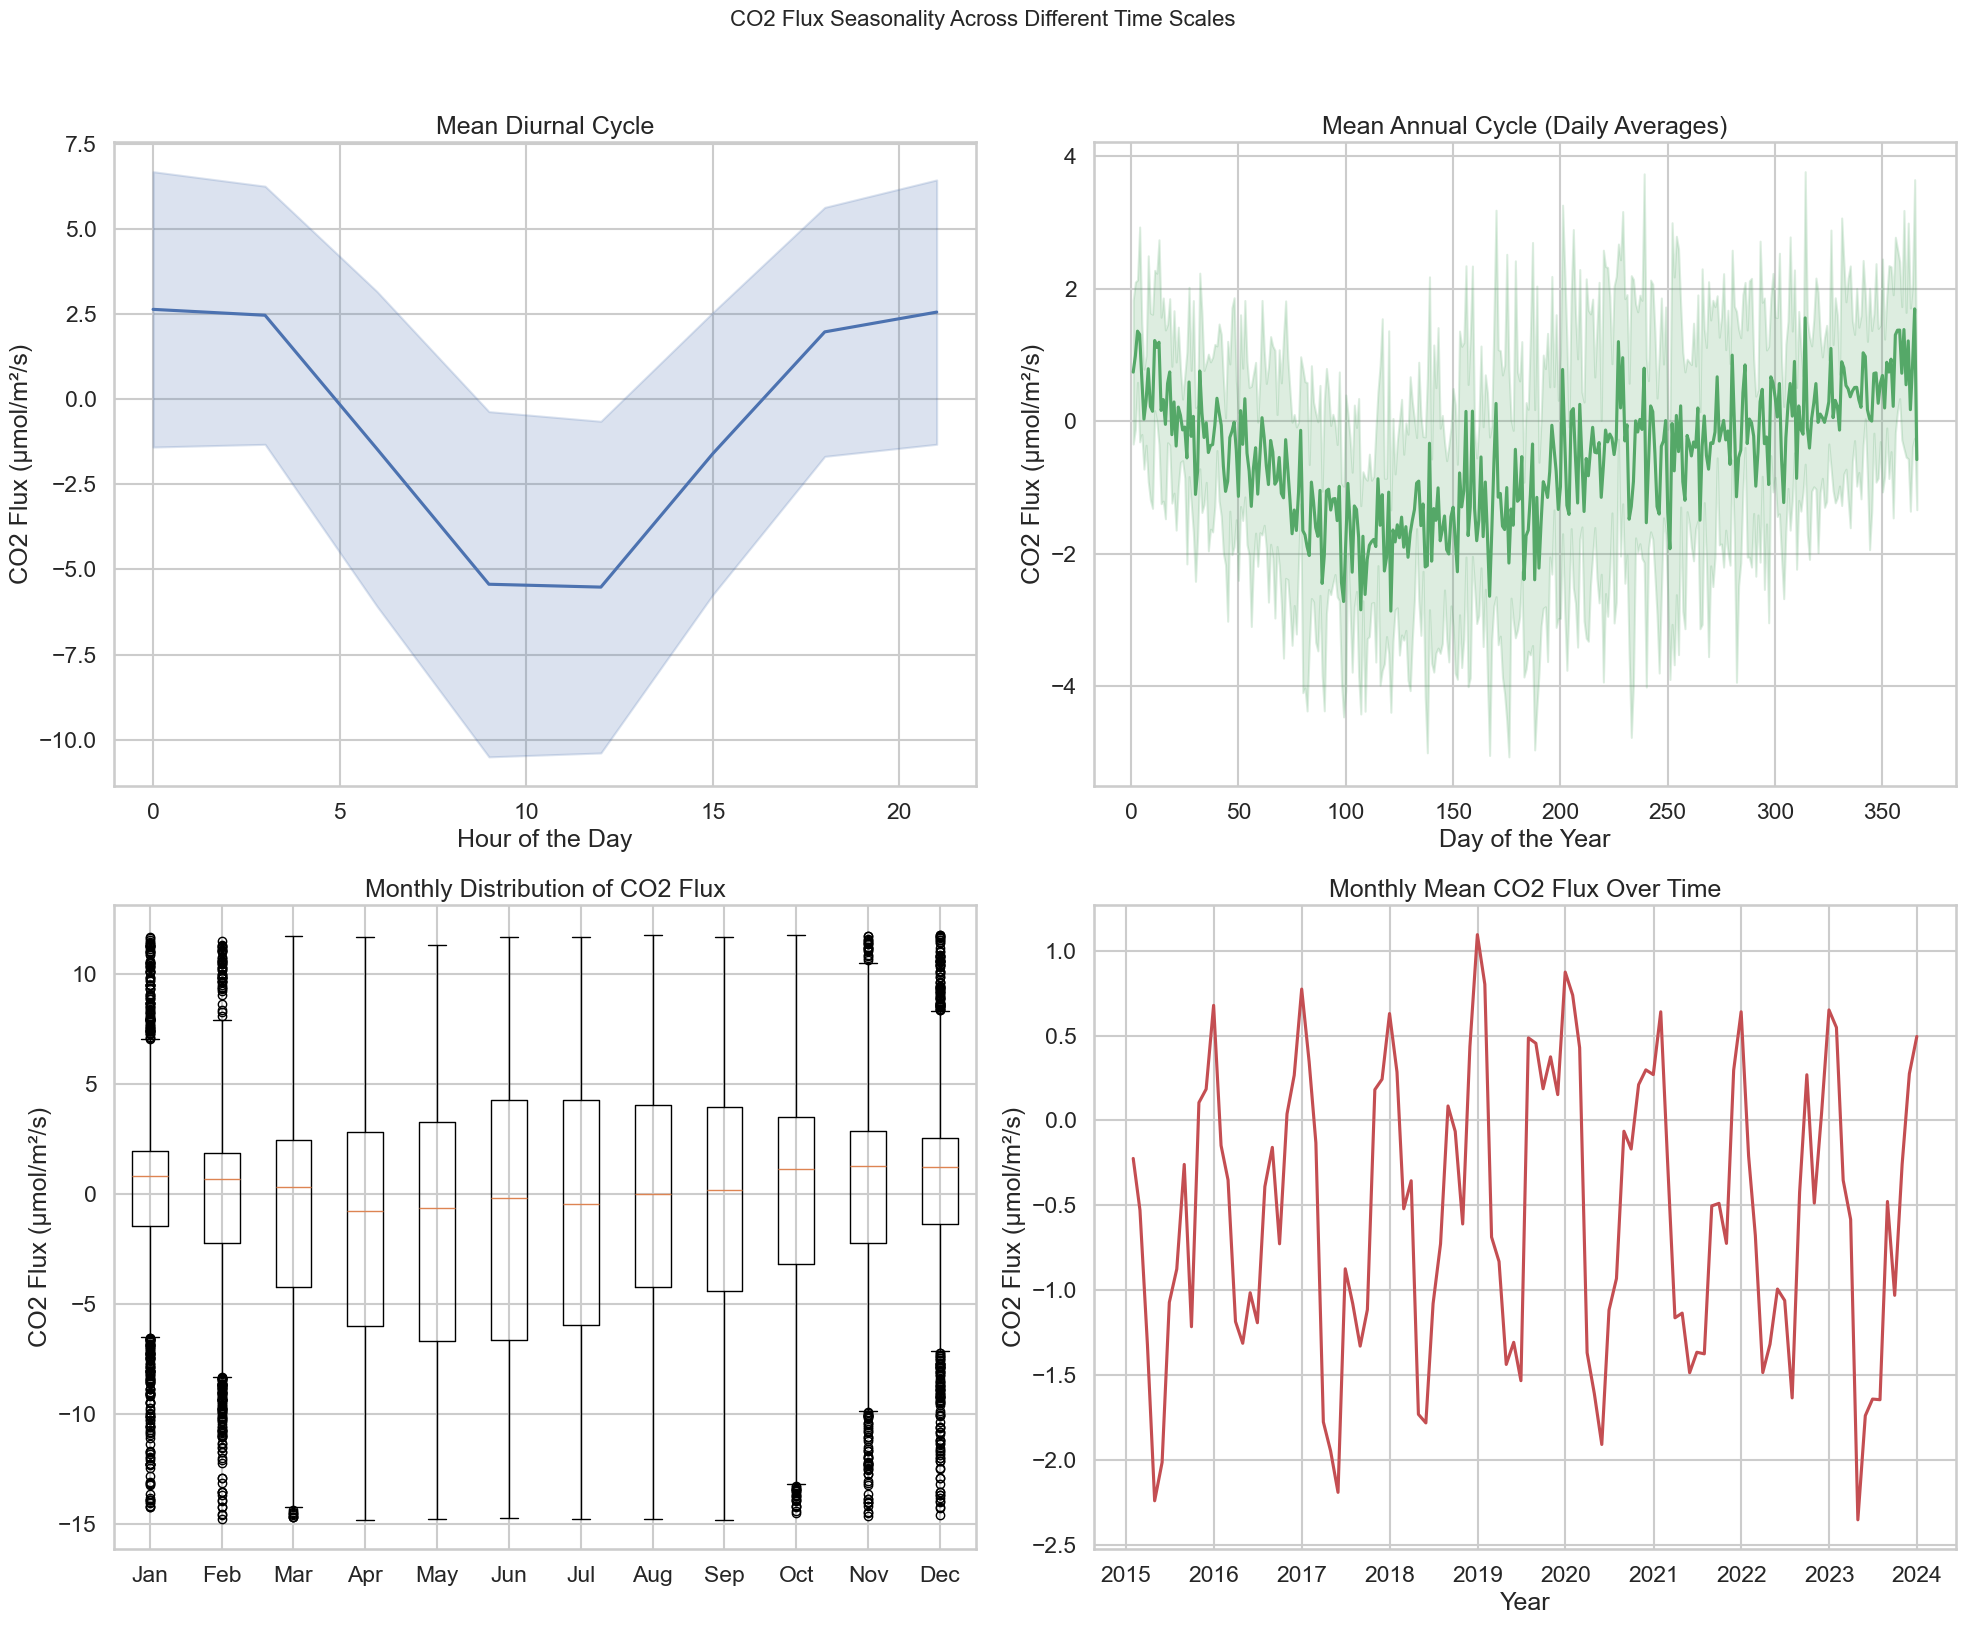


Statistical Summary of Seasonality:

1. Diurnal Cycle:
Maximum mean flux occurs at 0 hours: 2.64
Minimum mean flux occurs at 12 hours: -5.52

2. Annual Cycle:
Maximum annual mean flux on day 365: 1.69
Minimum annual mean flux on day 121: -2.87

3. Seasonal Amplitudes:
Diurnal Amplitude: 8.16
Annual Amplitude: 4.56


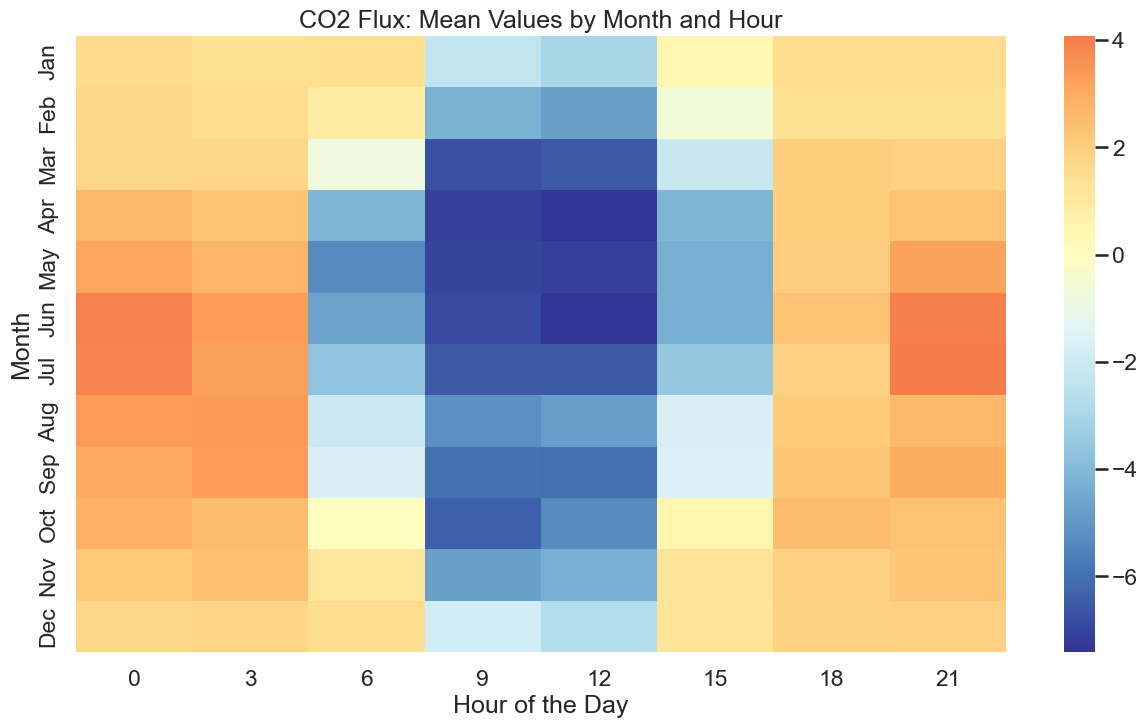

In [20]:


def analyze_seasonality(data):
    """
    Analyzes and visualizes the seasonality of CO2 flux across different time scales.
    
    Args:
        data: Pandas Series with a DateTime index (e.g., flux_df['co2_flux_filled']).
    
    Returns:
        A tuple containing:
        - daily: DataFrame with mean and standard deviation of diurnal variations.
        - yearly_grouped: DataFrame with mean and standard deviation of annual variations.
        - monthly_means: DataFrame with mean CO2 flux for each month over multiple years.
    """
    
    # Convert input Series to a DataFrame for easier manipulation
    df = pd.DataFrame({'co2_flux': data})
    
    # Initialize figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('CO2 Flux Seasonality Across Different Time Scales', fontsize=16, y=1.02)
    
    # 1. Diurnal cycle analysis (mean and standard deviation)
    daily = df.groupby(df.index.hour)['co2_flux'].agg(['mean', 'std'])
    axes[0, 0].plot(daily.index, daily['mean'], 'b-', label='Mean')
    axes[0, 0].fill_between(daily.index, 
                            daily['mean'] - daily['std'],
                            daily['mean'] + daily['std'],
                            alpha=0.2, color='b')
    axes[0, 0].set_title('Mean Diurnal Cycle')
    axes[0, 0].set_xlabel('Hour of the Day')
    axes[0, 0].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[0, 0].grid(True)
    
    # 2. Annual cycle analysis (daily means)
    yearly = df.resample('D').mean()
    yearly_grouped = yearly.groupby(yearly.index.dayofyear)['co2_flux'].agg(['mean', 'std'])
    axes[0, 1].plot(yearly_grouped.index, yearly_grouped['mean'], 'g-', label='Mean')
    axes[0, 1].fill_between(yearly_grouped.index,
                            yearly_grouped['mean'] - yearly_grouped['std'],
                            yearly_grouped['mean'] + yearly_grouped['std'],
                            alpha=0.2, color='g')
    axes[0, 1].set_title('Mean Annual Cycle (Daily Averages)')
    axes[0, 1].set_xlabel('Day of the Year')
    axes[0, 1].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[0, 1].grid(True)
    
    # 3. Monthly boxplots for variability analysis
    monthly = df.groupby(df.index.month)['co2_flux']
    axes[1, 0].boxplot([monthly.get_group(i) for i in range(1, 13)],
                       labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes[1, 0].set_title('Monthly Distribution of CO2 Flux')
    axes[1, 0].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[1, 0].grid(True)
    
    # 4. Long-term monthly mean trends
    monthly_means = df.resample('M').mean()
    axes[1, 1].plot(monthly_means.index, monthly_means['co2_flux'], 'r-')
    axes[1, 1].set_title('Monthly Mean CO2 Flux Over Time')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('CO2 Flux (μmol/m²/s)')
    axes[1, 1].grid(True)
    
    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()
    
    # Display statistical insights related to seasonality
    print("\nStatistical Summary of Seasonality:")
    
    print("\n1. Diurnal Cycle:")
    print(f"Maximum mean flux occurs at {daily['mean'].idxmax()} hours: {daily['mean'].max():.2f}")
    print(f"Minimum mean flux occurs at {daily['mean'].idxmin()} hours: {daily['mean'].min():.2f}")
    
    print("\n2. Annual Cycle:")
    print(f"Maximum annual mean flux on day {yearly_grouped['mean'].idxmax()}: {yearly_grouped['mean'].max():.2f}")
    print(f"Minimum annual mean flux on day {yearly_grouped['mean'].idxmin()}: {yearly_grouped['mean'].min():.2f}")
    
    # Compute seasonal amplitudes for daily and yearly cycles
    daily_range = daily['mean'].max() - daily['mean'].min()
    yearly_range = yearly_grouped['mean'].max() - yearly_grouped['mean'].min()
    
    print("\n3. Seasonal Amplitudes:")
    print(f"Diurnal Amplitude: {daily_range:.2f}")
    print(f"Annual Amplitude: {yearly_range:.2f}")
    
    # Generate heatmap of CO2 flux variations across months and hours
    pivot_data = df.pivot_table(
        values='co2_flux',
        index=df.index.month,
        columns=df.index.hour,
        aggfunc='mean'
    )
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data, 
                cmap='RdYlBu_r',
                center=0,
                yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.title('CO2 Flux: Mean Values by Month and Hour')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Month')
    plt.show()
    
    return daily, yearly_grouped, monthly_means

# Execute the seasonality analysis
daily_patterns, yearly_patterns, monthly_trends = analyze_seasonality(flux_df['co2_flux_filled'])

# Optional: Save the results for further analysis
# daily_patterns.to_csv('daily_patterns.csv')
# yearly_patterns.to_csv('yearly_patterns.csv')
# monthly_trends.to_csv('monthly_trends.csv')

# Data Manipulation

### Try to optimize parameters via grid search but failed

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed, Memory

def evaluate_sarimax_cached(y, X, params, train_idx, test_idx, seasonal_period):
    """
    Evaluiert das SARIMAX-Modell für gegebene Parameter und Indices.
    y, X: numpy-Arrays der Zeitreihe bzw. exogenen Variablen.
    train_idx, test_idx: Listen mit Indices.
    """
    y_train = y[train_idx]
    y_test = y[test_idx]
    X_train = X[train_idx] if X is not None else None
    X_test = X[test_idx] if X is not None else None
    p, d, q, P, D, Q, s = params
    try:
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False,
            initialization='approximate_diffuse'
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results = model.fit(disp=False, maxiter=200, method='powell')
        forecast = results.get_forecast(steps=len(y_test), exog=X_test)
        predictions = forecast.predicted_mean
        return {
            'params': params,
            'metrics': {
                'mae': mean_absolute_error(y_test, predictions),
                'mse': mean_squared_error(y_test, predictions),
                'rmse': np.sqrt(mean_squared_error(y_test, predictions)),
                'aic': results.aic
            },
            'status': 'success'
        }
    except Exception as e:
        return {
            'params': params,
            'metrics': {'mae': np.inf, 'mse': np.inf, 'rmse': np.inf, 'aic': np.inf},
            'status': str(e)
        }
    finally:
        gc.collect()

def custom_time_series_split(y, n_splits, test_size):
    n_samples = len(y)
    indices = np.arange(n_samples)
    for i in range(n_splits):
        test_start = n_samples - test_size * (n_splits - i)
        if test_start < 0:
            raise ValueError(f"Nicht genügend Daten für {n_splits} Splits mit test_size {test_size}")
        train_idx = indices[:test_start]
        test_idx = indices[test_start:test_start + test_size]
        yield train_idx.tolist(), test_idx.tolist()

def worker_wrapper(y, X, params, train_idx, test_idx, seasonal_period):
    res = evaluate_sarimax_cached(y, X, params, train_idx, test_idx, seasonal_period)
    print(f"Worker finished for parameters: {params} with status: {res['status']}", flush=True)
    return res



class SARIMAXGridSearch:
    def __init__(self, y, X=None, seasonal_period=24):
        self.y = np.asarray(y, dtype=np.float64)
        self.X = np.asarray(X, dtype=np.float64) if X is not None else None
        self.seasonal_period = seasonal_period
        self.cache_dir = Path("./cache")
        self.cache_dir.mkdir(exist_ok=True)
        self.memory = Memory(location=str(self.cache_dir), verbose=0)
    
    def grid_search(self, param_grid, cv_splits=3, n_jobs=4):
        test_size = self.seasonal_period * 7
        cv = list(custom_time_series_split(self.y, cv_splits, test_size))
        
        param_combinations = [
            (p, d, q, P, D, Q, self.seasonal_period)
            for p in param_grid['p']
            for d in param_grid['d']
            for q in param_grid['q']
            for P in param_grid['P']
            for D in param_grid['D']
            for Q in param_grid['Q']
        ]
        
        results = []
        cached_worker = self.memory.cache(worker_wrapper)

        for fold_idx, (train_idx, test_idx) in enumerate(cv, 1):
            print(f"\nProcessing fold {fold_idx}/{cv_splits}")
            
            # Cache-Check für diese Faltung
            cached_for_fold = []
            for params in param_combinations:
                if cached_worker.check_call_in_cache(
                    self.y, self.X, params, train_idx, test_idx, self.seasonal_period
                ):
                    cached_for_fold.append(params)
            
            if cached_for_fold:
                print(f"🔄 Gefundene gecachte Ergebnisse ({len(cached_for_fold)}):")
                for p in cached_for_fold:
                    print(f"  SARIMAX({p[0]},{p[1]},{p[2]})x({p[3]},{p[4]},{p[5]},{p[6]})")
                print(f"Neue Berechnungen: {len(param_combinations)-len(cached_for_fold)}")
            else:
                print("ℹ️ Keine gecachten Ergebnisse gefunden, starte alle Berechnungen neu")

            fold_results = Parallel(n_jobs=n_jobs, verbose=10)(
                delayed(cached_worker)(
                    self.y,
                    self.X,
                    params,
                    train_idx,
                    test_idx,
                    self.seasonal_period
                ) for params in param_combinations
            )
            
            successful = [r for r in fold_results if r['status'] == 'success']
            results.extend(successful)
            print(f"✅ Fold {fold_idx} abgeschlossen - Erfolgreich: {len(successful)}")

        if not results:
            raise ValueError("Keine erfolgreichen Modellanpassungen")

        results_df = pd.DataFrame([{
            'p': r['params'][0],
            'd': r['params'][1],
            'q': r['params'][2],
            'P': r['params'][3],
            'D': r['params'][4],
            'Q': r['params'][5],
            'mae': r['metrics']['mae'],
            'mse': r['metrics']['mse'],
            'rmse': r['metrics']['rmse'],
            'aic': r['metrics']['aic'],
            'status': r['status']
        } for r in results])
        
        best_params = results_df.loc[results_df.groupby(['p','d','q','P','D','Q'])['aic'].idxmin()]
        return {
            'best_params': best_params.iloc[0][['p','d','q','P','D','Q']].to_dict(),
            'results': results_df,
            'best_model_stats': best_params.iloc[0]
        }

# --- Nutzung im Notebook ---

# Beispiel: flux_df ist Dein DataFrame mit einem DatetimeIndex und den Spalten 'co2_flux_filled' und 'SW_IN'
flux_df_hourly = flux_df.resample('h').mean().dropna()

y = flux_df_hourly['co2_flux_filled'].values.astype(np.float64)
X = flux_df_hourly[['SW_IN']].values.astype(np.float64)

param_grid = {
    'p': [0, 1, 2],
    'd': [0, 1],
    'q': [0, 1, 2],
    'P': [0, 1],
    'D': [0, 1],
    'Q': [0, 1]
}

searcher = SARIMAXGridSearch(y, X, seasonal_period=24)
results = searcher.grid_search(param_grid, cv_splits=3, n_jobs=-1)

print("\nBeste Parameter gefunden:")
print(results['best_params'])

NameError: name 'flux_df' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from joblib import Parallel, delayed, Memory
from pathlib import Path
import gc
import warnings

# 1. Datenvorbereitung mit Saisonalitäts-Features
def prepare_data(df):
    df_hourly = df.resample('h').mean().dropna()

    # Fourier-Features für jährliche Saisonalität
    df_hourly['fourier_sin'] = np.sin(2 * np.pi * df_hourly.index.dayofyear / 365)
    df_hourly['fourier_cos'] = np.cos(2 * np.pi * df_hourly.index.dayofyear / 365)

    # Trend-Feature
    df_hourly['linear_trend'] = np.arange(len(df_hourly)) / len(df_hourly)

    return df_hourly

# 2. Stationaritäts-Checks
def check_stationarity(series):
    print("\n--- Stationaritätsanalyse ---")

    # ADF-Test
    adf = adfuller(series.dropna())
    print(f"ADF p-value: {adf[1]:.4f}")

    # KPSS-Test
    kpss_test = kpss(series.dropna(), regression='ct')
    print(f"KPSS p-value: {kpss_test[1]:.4f}")

    # Visual Check
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    series.plot(ax=ax[0], title="Original Series")
    series.diff(24).dropna().plot(ax=ax[1], title="24h Differenced Series")
    plt.tight_layout()
    plt.show()

# Top-level Funktion für das Modell-Fitting, um Pickling-Probleme zu vermeiden
def fit_model_func(y, X, seasonal_period, params):
    p, d, q, P, D, Q = params
    # Wird nur ausgeführt, wenn kein Cacheeintrag existiert
    print(f"Kein Cache gefunden, berechne Modell für Parameterkombination: {params}")
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = SARIMAX(
                y,
                exog=X,
                order=(p, d, q),
                seasonal_order=(P, D, Q, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(method='lbfgs', maxiter=100, disp=False, low_memory=True)

            if np.any(np.abs(result.arparams) > 1) or np.any(np.abs(result.maparams) > 1):
                raise ValueError("Nicht-invertible Parameter")

            return {
                'params': params,
                'aic': result.aic,
                'bic': result.bic,
                'converged': True
            }
    except Exception as e:
        return {
            'params': params,
            'error': str(e),
            'converged': False
        }
    finally:
        gc.collect()

# 3. Optimierte Grid Search Klasse
class AdvancedSARIMAXSearch:
    def __init__(self, y, X=None, seasonal_period=24):
        """
        Initialisiert die erweiterte Grid-Suche für SARIMAX-Modelle.
        """
        self.y = y.astype(np.float32)
        self.X = X.astype(np.float32) if X is not None else None
        self.seasonal_period = seasonal_period
        self.cache_dir = Path("./sarimax_cache")
        self.cache_dir.mkdir(exist_ok=True)
        self.memory = Memory(location=str(self.cache_dir), verbose=0)

    def search(self, param_grid, n_jobs=-1):
        """
        Führt eine Grid-Suche mit den angegebenen Parametern durch.
        """
        self._validate_grid(param_grid)
        combinations = [
            (p, d, q, P, D, Q)
            for p in param_grid['p']
            for d in param_grid['d']
            for q in param_grid['q']
            for P in param_grid['P']
            for D in param_grid['D']
            for Q in param_grid['Q']
        ]
        
        # Cached-Funktion erstellen
        cached_fit = self.memory.cache(fit_model_func)

        # Wrapper-Funktion mit zusätzlichen Print-Ausgaben
        def cached_fit_with_print(params):
            print(f"\n>>> Verarbeite Parameterkombination: {params} ...", flush=True)
            result = cached_fit(self.y, self.X, self.seasonal_period, params)
            print(f"<<< Parameterkombination {params} abgeschlossen.", flush=True)
            return result

        results = []
        chunk_size = 10
        num_chunks = (len(combinations) + chunk_size - 1) // chunk_size
        for i in range(num_chunks):
            chunk = combinations[i * chunk_size : (i + 1) * chunk_size]
            print(f"\n=== Verarbeite Chunk {i + 1} von {num_chunks} (Kombinationen: {chunk}) ===")
            chunk_results = Parallel(n_jobs=n_jobs, verbose=11, backend='loky')(
                delayed(cached_fit_with_print)(params) for params in chunk
            )
            results.extend(chunk_results)
            print(f"=== Chunk {i + 1} abgeschlossen. ===")

        valid_results = [r for r in results if r.get('converged', False)]
        if not valid_results:
            raise ValueError("Keine konvergierten Modelle", flush=True)

        df = pd.DataFrame(valid_results).sort_values('aic')
        self._plot_results(df)
        return df

    def _validate_grid(self, grid):
        required = ['p', 'd', 'q', 'P', 'D', 'Q']
        if any(k not in grid for k in required):
            missing = [k for k in required if k not in grid]
            raise ValueError(f"Fehlende Parameter: {missing}")

    def _plot_results(self, results_df):
        plt.figure(figsize=(10, 6))
        plt.bar(results_df['params'].astype(str), results_df['aic'])
        plt.title("AIC-Werte der Modellkombinationen")
        plt.xlabel("Parameterkombination")
        plt.ylabel("AIC")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

# 4. Hauptworkflow
if __name__ == "__main__":
    flux_filtered = flux_df.loc['2019-01-01':'2019-05-31']
    # Annahme: flux_df ist bereits im Workspace vorhanden
    flux_df_hourly = prepare_data(flux_filtered.copy())  # flux_df kopieren, um Originaldaten zu schützen

    # Stationaritätsprüfung
    check_stationarity(flux_df_hourly['co2_flux_filled'])

    # Datenkonvertierung
    y = flux_df_hourly['co2_flux_filled'].values.astype(np.float32)
    X = flux_df_hourly[['SW_IN', 'fourier_sin', 'fourier_cos', 'linear_trend']].values.astype(np.float32)

    # Parameter Grid
    param_grid = {
        'p': [1, 2],
        'd': [0, 1],
        'q': [1, 2],
        'P': [1],
        'D': [1],
        'Q': [1]
    }

    # Grid Search durchführen
    searcher = AdvancedSARIMAXSearch(y, X, seasonal_period=24)
    results = searcher.search(param_grid, n_jobs=-1)

    # Bestes Modell auswählen
    best_params = results.iloc[0]['params']
    print(f"\n🏆 Beste Parameterkombination: {best_params}")

    # Finales Modell trainieren
    final_model = SARIMAX(
        y,
        exog=X,
        order=best_params[:3],
        seasonal_order=best_params[3:] + (24,)
    ).fit(disp=False)

    # Diagnostik-Plots
    final_model.plot_diagnostics(figsize=(15, 12))
    plt.show()

    # Zusammenfassung
    print(final_model.summary())

### SARIMAX optimize parameters via grid search


 Determining optimal differencing order...


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: F

Recommended differencing orders: d=0, D=0


<Figure size 1500x600 with 0 Axes>

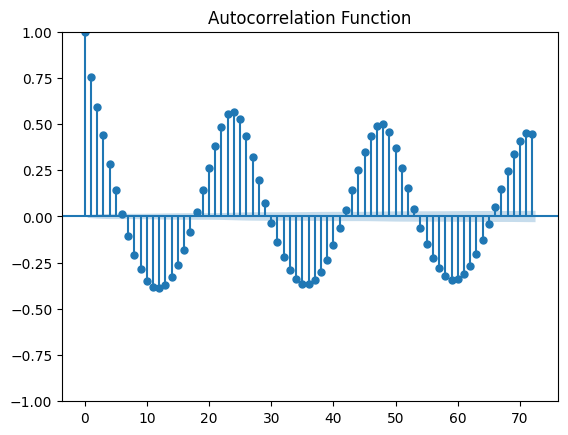

<Figure size 1500x600 with 0 Axes>

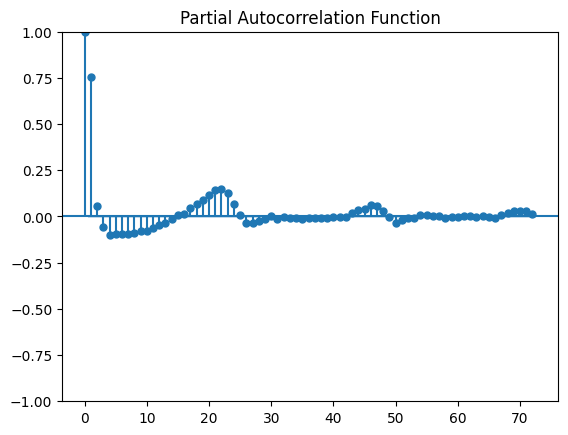

Dask cluster initialized: <Client: 'tcp://127.0.0.1:55945' processes=4 threads=8, memory=14.90 GiB>

Starting parallel model search...

Best Model (AIC 318730.3):
SARIMAX(1, 0, 1)x(1, 0, 1, 24)


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


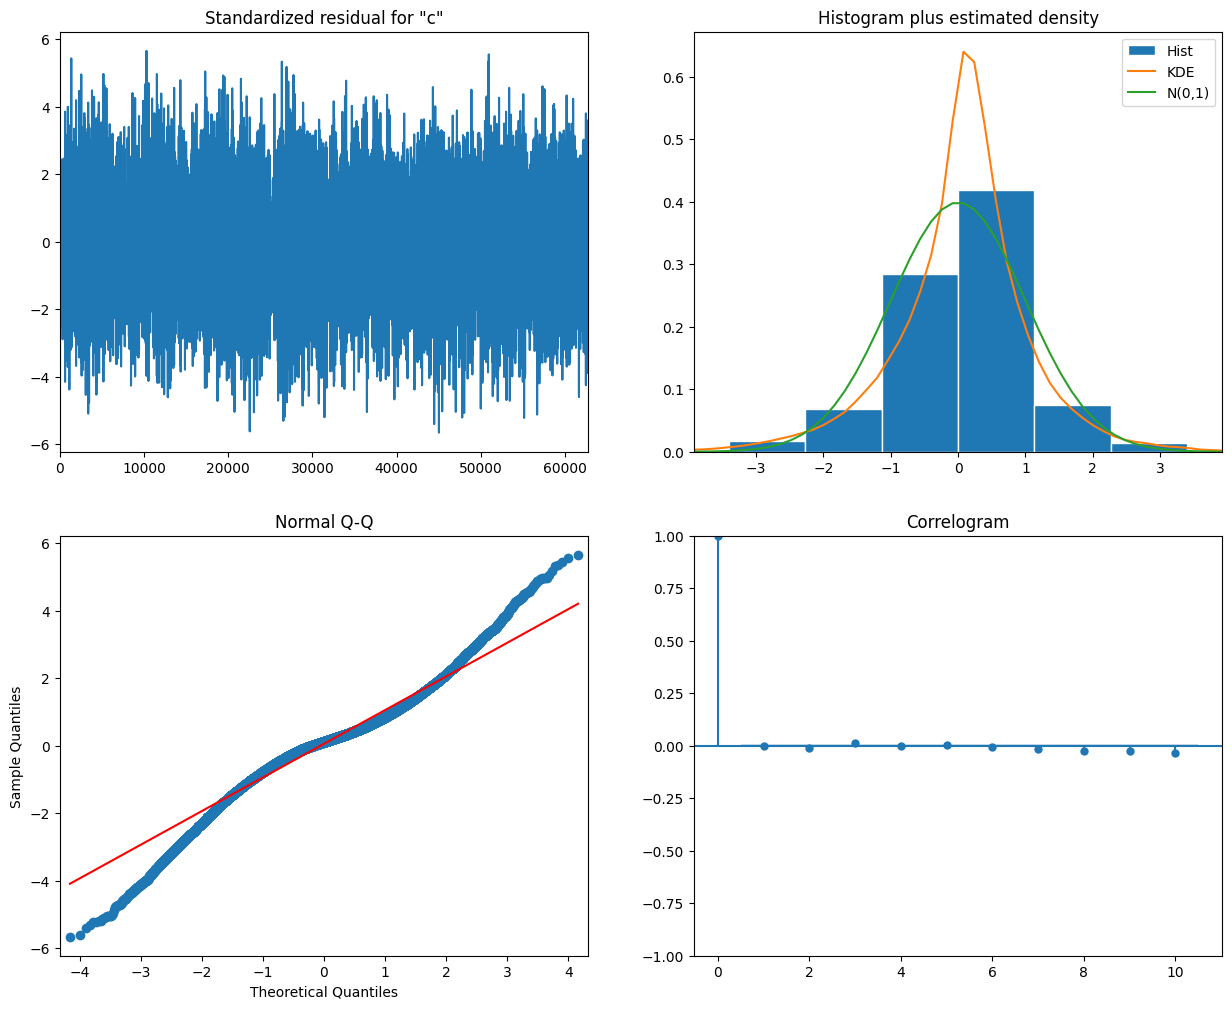

                                     SARIMAX Results                                      
Dep. Variable:                    co2_flux_filled   No. Observations:                62749
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -159204.596
Date:                            Mon, 03 Mar 2025   AIC                         318421.191
Time:                                    15:08:18   BIC                         318475.472
Sample:                                         0   HQIC                        318438.017
                                          - 62749                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SW_IN         -0.0118      0.000   -114.143      0.000      -0.012      -0.012
ar.L1          0.6796      0.005   

In [18]:
# 1. Memory-Optimized Data Preparation
def prepare_data(df, start_date, end_date):
    """Cleans and transforms the input data."""
    df = df.loc[start_date:end_date].resample('h').mean()
    
    # Memory optimizations
    numeric_cols = df.select_dtypes(np.float64).columns
    df[numeric_cols] = df[numeric_cols].astype(np.float32)
    
    # Reduce to required columns
    df = df[['co2_flux_filled', 'SW_IN']].copy()
    return df.dropna()

# 2. Automated Differencing Determination
def determine_differencing(y):
    """Determines the optimal order of differencing using statistical tests."""
    print("\n Determining optimal differencing order...")
    
    # Non-seasonal differencing
    d = ndiffs(y, test='adf', max_d=2)
    
    # Seasonal differencing (24h)
    D = nsdiffs(y, m=24, test='ocsb', max_D=2)
    
    print(f"Recommended differencing orders: d={d}, D={D}")
    return d, D

# 3. Seasonality Analysis
def analyze_seasonality(y, lags=72):
    """Performs ACF/PACF analysis."""
    plt.figure(figsize=(15, 6))
    plot_acf(y, lags=lags, alpha=0.05, title="Autocorrelation Function")
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plot_pacf(y, lags=lags, alpha=0.05, title="Partial Autocorrelation Function")
    plt.show()

# 4. Parallelization Setup
def initialize_cluster():
    """Starts a Dask cluster for parallel computations."""
    client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB')
    print("Dask cluster initialized:", client)
    return client

# 5. SARIMAX Model Fitting with Robust Error Handling
@dask.delayed
def fit_sarimax(y, X, order, seasonal_order):
    """Fits a SARIMAX model with robust error handling."""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            model = SARIMAX(
                endog=y.astype(np.float32),
                exog=X.astype(np.float32) if X is not None else None,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True,
                initialization='approximate_diffuse'
            )
            
            result = model.fit(
                method='powell',
                maxiter=50,
                disp=False,
                low_memory=True
            )
            
            return {
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': result.aic,
                'bic': result.bic,
                'mae': mean_absolute_error(y, result.fittedvalues)
            }
            
    except Exception as e:
        print(f"Error with {order}{seasonal_order}: {str(e)[:80]}")
        return None
    finally:
        gc.collect()

# 6. Main Workflow with Extended Validations

# Load data
df = prepare_data(flux_df, '2015-01-01', '2023-12-31')

# Split data into train and test sets
train_end = '2022-12-31'
train_data = df.loc[:train_end]
test_data = df.loc[train_end:]

y_train = train_data['co2_flux_filled']
X_train = train_data[['SW_IN']]
y_test = test_data['co2_flux_filled']
X_test = test_data[['SW_IN']]

# Determine differencing orders
d, D = determine_differencing(y_train)

# Seasonality analysis
analyze_seasonality(y_train)

# Parameter grid based on ACF/PACF
param_grid = {
    'p': [0, 1, 2],
    'q': [0, 1, 2],
    'P': [0, 1],
    'Q': [0, 1]
}

# Initialize cluster
client = initialize_cluster()

# Parallelized grid search
print("\nStarting parallel model search...")
tasks = []
for p in param_grid['p']:
    for q in param_grid['q']:
        for P in param_grid['P']:
            for Q in param_grid['Q']:
                tasks.append(
                    fit_sarimax(
                        y_train.values,
                        X_train.loc[y_train.index].values if X_train is not None else None,
                        (p, d, q),
                        (P, D, Q, 24)
                    )
                )

# Process results
results = dask.compute(*tasks)
valid_results = [r for r in results if r is not None]

if not valid_results:
    raise ValueError("No models successfully fitted")

results_df = pd.DataFrame(valid_results).sort_values('aic')

# Output best model
best_model = results_df.iloc[0]
print(f"\nBest Model (AIC {best_model.aic:.1f}):")
print(f"SARIMAX{best_model.order}x{best_model.seasonal_order}")

# Train final model
final_model = SARIMAX(
    y_train,
    exog=X_train.loc[y_train.index] if X_train is not None else None,
    order=best_model.order,
    seasonal_order=best_model.seasonal_order
).fit(disp=True)

# Diagnostics
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()
print(final_model.summary())

# Close cluster
client.close()



/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


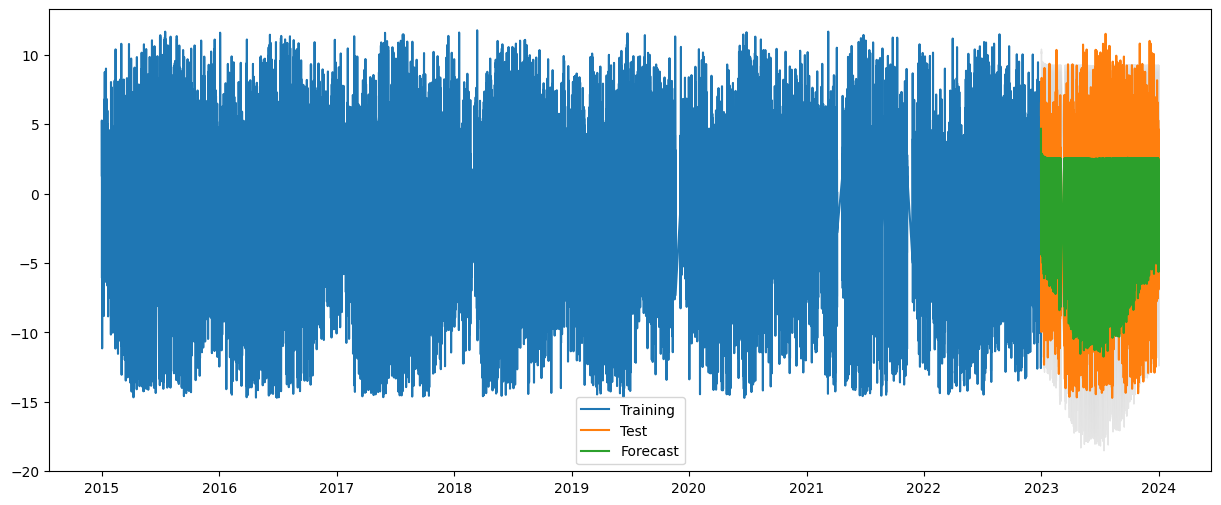

MAE: 2.722
RMSE: 3.613


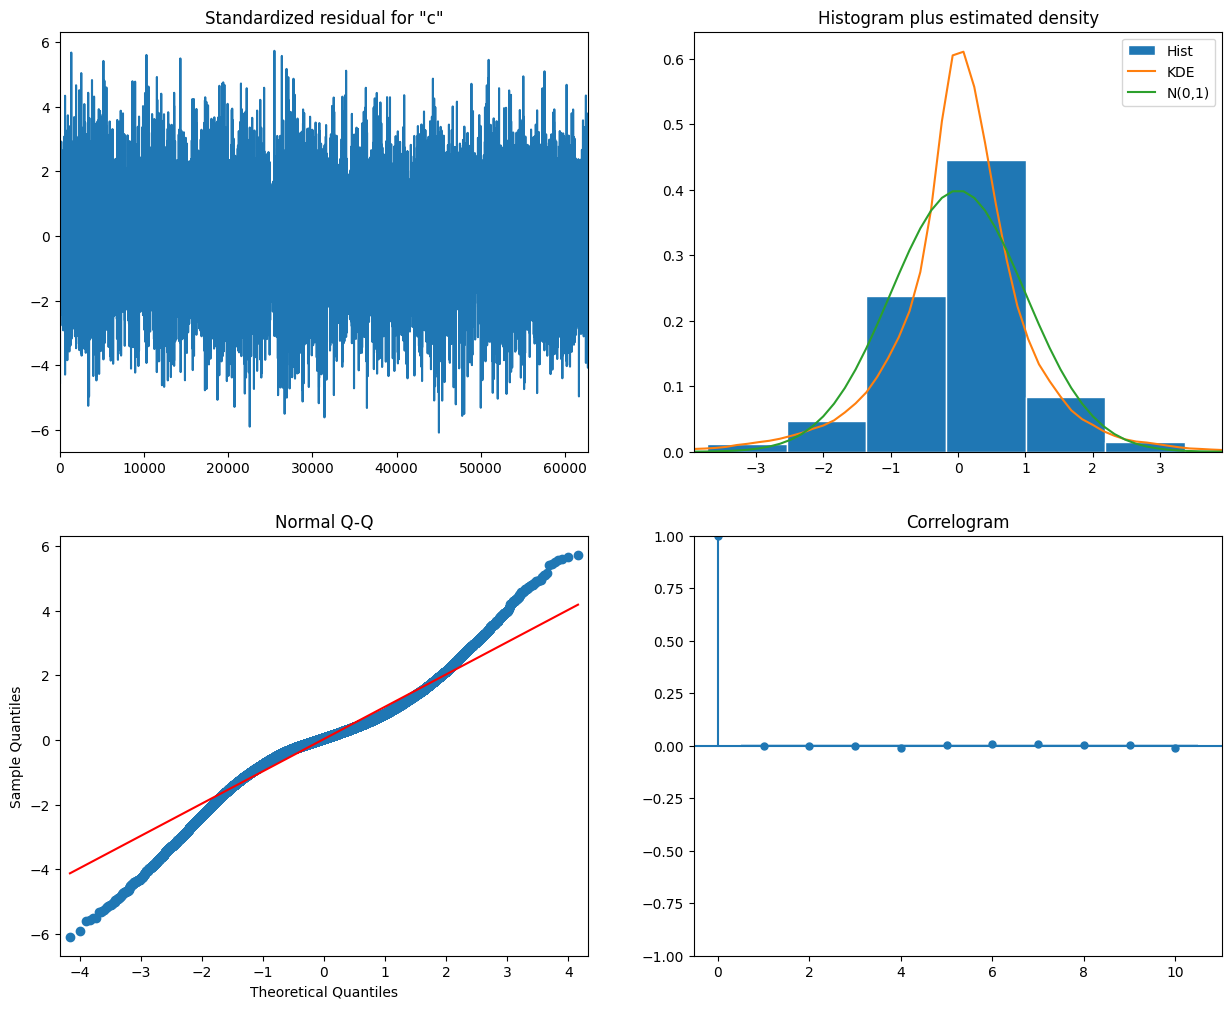

                                     SARIMAX Results                                      
Dep. Variable:                    co2_flux_filled   No. Observations:                62749
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -156819.649
Date:                            Mon, 03 Mar 2025   AIC                         313665.298
Time:                                    16:19:10   BIC                         313782.908
Sample:                                         0   HQIC                        313701.754
                                          - 62749                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SW_IN         -0.0076      0.000    -69.631      0.000      -0.008      -0.007
sin_1         -0.3288      0.041   

In [21]:
# Prognose für den Testzeitraum
forecast_steps = len(test_data)
forecast = final_model.get_forecast(steps=forecast_steps, exog=X_test if X_test is not None else None)
forecast_ci = forecast.conf_int()

# Visualisierung: Trainingsdaten, Testdaten und Prognose
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, y_train, label="Training")
plt.plot(test_data.index, y_test, label="Test")
plt.plot(test_data.index, forecast.predicted_mean, label="Forecast")
plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.show()

# Evaluation: Vorhersagegenauigkeit


mae = mean_absolute_error(y_test, forecast.predicted_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast.predicted_mean))
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# Diagnostics des finalen Modells
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()
print(final_model.summary())



 Determining optimal differencing order...


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: F

Recommended differencing orders: d=0, D=0


<Figure size 1500x600 with 0 Axes>

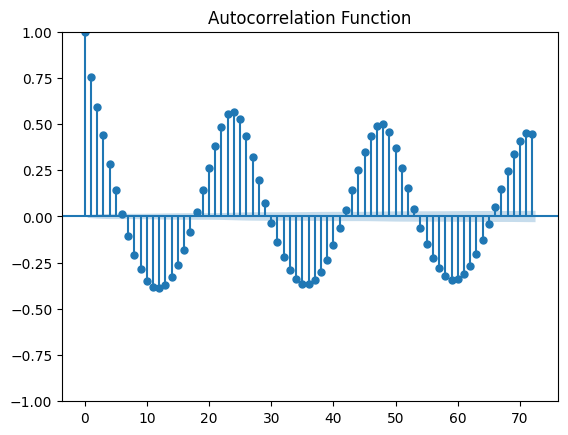

<Figure size 1500x600 with 0 Axes>

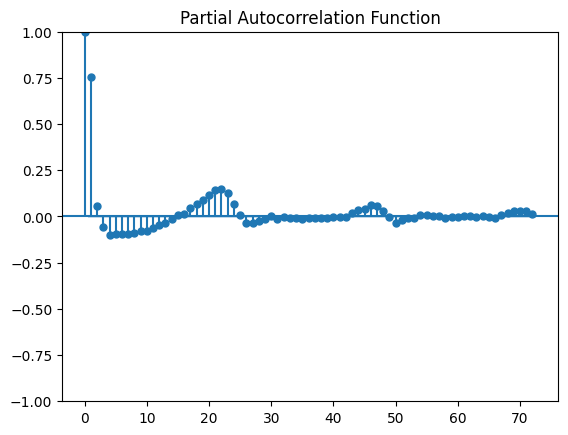

/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61289 instead
  warnings.warn(


Dask cluster initialized: <Client: 'tcp://127.0.0.1:61290' processes=8 threads=32, memory=29.80 GiB>

Starting parallel model search...


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 207.06 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



Best Model (AIC 314213.4):
SARIMAX(2, 0, 1)x(1, 0, 1, 24)


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


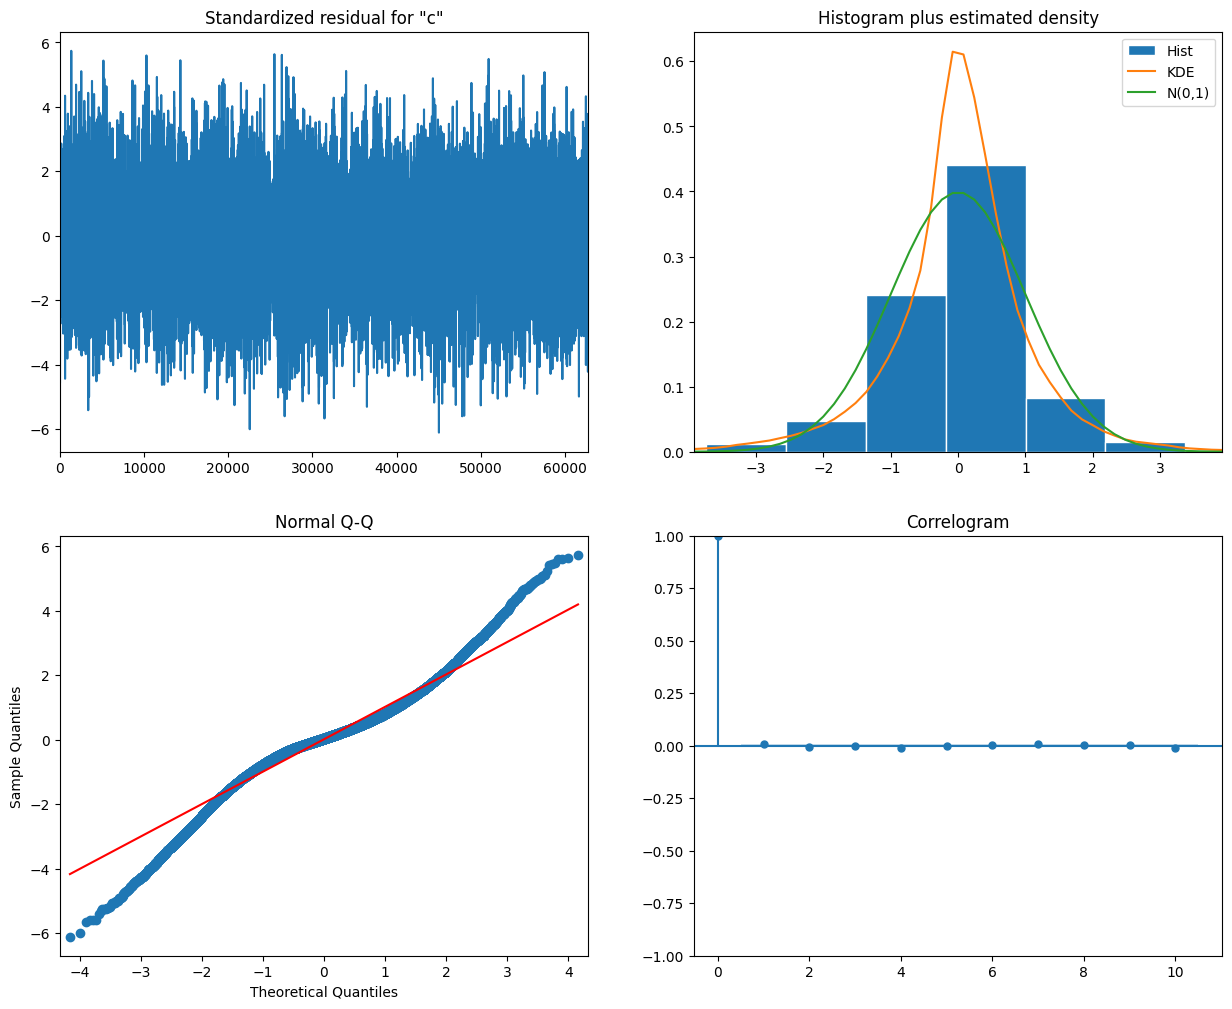

                                     SARIMAX Results                                      
Dep. Variable:                    co2_flux_filled   No. Observations:                62749
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -156774.982
Date:                            Mon, 03 Mar 2025   AIC                         313585.963
Time:                                    18:36:04   BIC                         313748.807
Sample:                                         0   HQIC                        313636.441
                                          - 62749                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SW_IN         -0.0080      0.000    -73.852      0.000      -0.008      -0.008
is_night       0.4518      0.065   

In [33]:
# 1. Memory-Optimized Data Preparation
def prepare_data(df, start_date, end_date):
    """Cleans and transforms the input data."""
    df = df.loc[start_date:end_date].resample('h').mean()
    
    # Memory optimizations
    numeric_cols = df.select_dtypes(np.float64).columns
    df[numeric_cols] = df[numeric_cols].astype(np.float32)
    
    # Reduce to required columns
    df = df[['co2_flux_filled', 'SW_IN']].copy()
    return df.dropna()

def create_fourier_terms(dates, freq=24, order=5):
    """
    Erstellt Fourier-Terme für Zeitreihen mit täglichem Zyklus.
    
    Args:
        dates: DatetimeIndex der Zeitreihe
        freq: Frequenz des Zyklus (24 für tägliche Daten mit stündlicher Auflösung)
        order: Anzahl der Fourier-Terme (höhere Ordnung = mehr Flexibilität)
    
    Returns:
        DataFrame mit Sinus- und Kosinus-Termen
    """
    fourier_terms = pd.DataFrame(index=dates)
    hours = pd.Series(dates.hour, index=dates)
    
    for i in range(1, order + 1):
        fourier_terms[f'sin_{i}'] = np.sin(2 * np.pi * i * hours / freq)
        fourier_terms[f'cos_{i}'] = np.cos(2 * np.pi * i * hours / freq)
    
    return fourier_terms

def add_is_night(df, start_hour=20, end_hour=6):
    """
    Erstellt eine Dummy-Variable is_night, die 1 ist, wenn die Stunde in [start_hour, 24) oder [0, end_hour),
    sonst 0. Standard: Nacht = 20 Uhr bis 6 Uhr.
    """
    df['is_night'] = ((df.index.hour >= start_hour) | (df.index.hour < end_hour)).astype(int)
    return df

# 2. Automated Differencing Determination
def determine_differencing(y):
    """Determines the optimal order of differencing using statistical tests."""
    print("\n Determining optimal differencing order...")
    
    # Non-seasonal differencing
    d = ndiffs(y, test='adf', max_d=2)
    
    # Seasonal differencing (24h)
    D = nsdiffs(y, m=24, test='ocsb', max_D=2)
    
    print(f"Recommended differencing orders: d={d}, D={D}")
    return d, D

# 3. Seasonality Analysis
def analyze_seasonality(y, lags=72):
    """Performs ACF/PACF analysis."""
    plt.figure(figsize=(15, 6))
    plot_acf(y, lags=lags, alpha=0.05, title="Autocorrelation Function")
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plot_pacf(y, lags=lags, alpha=0.05, title="Partial Autocorrelation Function")
    plt.show()

# 4. Parallelization Setup
def initialize_cluster():
    """Starts a Dask cluster for parallel computations."""
    client = Client(n_workers=8, threads_per_worker=4, memory_limit='4GB')
    print("Dask cluster initialized:", client)
    return client

# 5. SARIMAX Model Fitting with Robust Error Handling
@dask.delayed
def fit_sarimax(y, X, order, seasonal_order):
    """Fits a SARIMAX model with robust error handling."""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            model = SARIMAX(
                endog=y.astype(np.float32),
                exog=X.astype(np.float32) if X is not None else None,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True,
                initialization='approximate_diffuse'
            )
            
            result = model.fit(
                method='powell',
                maxiter=50,
                disp=False,
                low_memory=True
            )
            
            return {
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': result.aic,
                'bic': result.bic,
                'mae': mean_absolute_error(y, result.fittedvalues)
            }
            
    except Exception as e:
        print(f"Error with {order}{seasonal_order}: {str(e)[:80]}")
        return None
    finally:
        gc.collect()

# 6. Main Workflow with Extended Validations

# 6.1Load data
df = prepare_data(flux_df, '2015-01-01', '2023-12-31')

# # Split data into train and test sets
# train_end = '2022-12-31'
# train_data = df.loc[:train_end]
# test_data = df.loc[train_end:]

# y_train = train_data['co2_flux_filled']
# X_train = train_data[['SW_IN']]
# y_test = test_data['co2_flux_filled']
# X_test = test_data[['SW_IN']]

# 6.2 is_night hinzufügen
df = add_is_night(df, start_hour=20, end_hour=6)

# 6.3 Fourier-Terme erstellen und anhängen
fourier_terms = create_fourier_terms(df.index, freq=24, order=5)
df = pd.concat([df, fourier_terms], axis=1)



# Split data into train and test sets
train_end = '2022-12-31'
train_data = df.loc[:train_end]
test_data = df.loc[train_end:]


# 6.4 Trainings- und Testdaten vorbereiten X,Y sind exogene Variablen
y_train = train_data['co2_flux_filled']
X_train = train_data.drop(columns=['co2_flux_filled'])
y_test = test_data['co2_flux_filled']
X_test = test_data.drop(columns=['co2_flux_filled'])

# Determine differencing orders
d, D = determine_differencing(y_train)

# Seasonality analysis
analyze_seasonality(y_train)

# Parameter grid based on ACF/PACF
param_grid = {
    'p': [0, 1, 2],
    'q': [0, 1, 2],
    'P': [0, 1],
    'Q': [0, 1]
}

# Initialize cluster
client = initialize_cluster()

# Parallelized grid search
print("\nStarting parallel model search...")
tasks = []
for p in param_grid['p']:
    for q in param_grid['q']:
        for P in param_grid['P']:
            for Q in param_grid['Q']:
                tasks.append(
                    fit_sarimax(
                        y_train.values,
                        X_train.loc[y_train.index].values if X_train is not None else None,
                        (p, d, q),
                        (P, D, Q, 24)
                    )
                )

# Process results
results = dask.compute(*tasks)
valid_results = [r for r in results if r is not None]

if not valid_results:
    raise ValueError("No models successfully fitted")

results_df = pd.DataFrame(valid_results).sort_values('aic')

# Output best model
best_model = results_df.iloc[0]
print(f"\nBest Model (AIC {best_model.aic:.1f}):")
print(f"SARIMAX{best_model.order}x{best_model.seasonal_order}")

# Train final model
final_model = SARIMAX(
    y_train,
    exog=X_train.loc[y_train.index] if X_train is not None else None,
    order=best_model.order,
    seasonal_order=best_model.seasonal_order
).fit(disp=True)

# Diagnostics
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()
print(final_model.summary())

# Close cluster
client.close()



/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


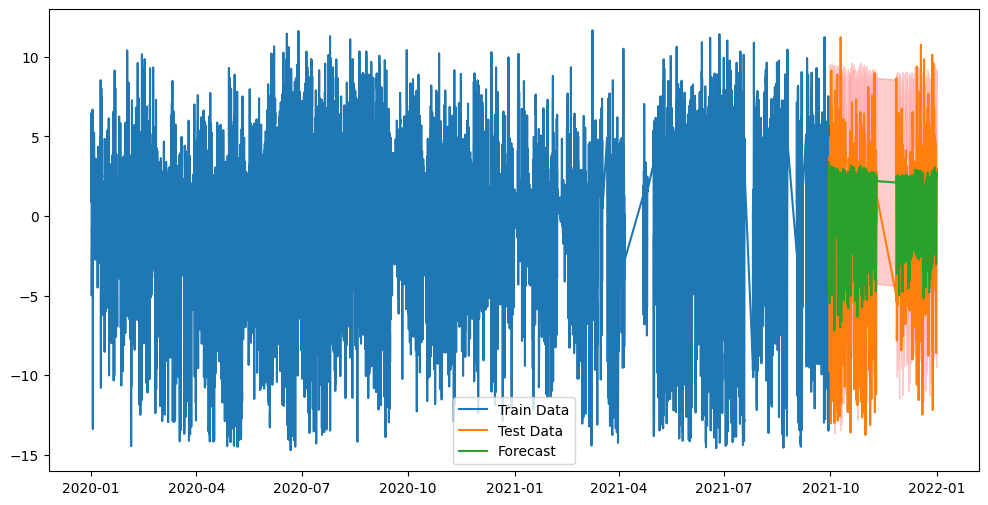

In [40]:
forecast_steps = len(X_test)
forecast = final_model.get_forecast(steps=forecast_steps, exog=X_test)

# Prognose und Konfidenzintervalle extrahieren
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Manuell den Index der Testdaten zuweisen:
forecast_mean.index = X_test.index
forecast_ci.index = X_test.index

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train Data')
plt.plot(y_test.index, y_test, label='Test Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.legend()
plt.show()

### Using a smaller training and test period to get the model to work.
Using auto_arima to find the best model, since grid search is not working. Grid search is too resource intensive.


2025-05-09 13:33:28,648 - INFO - 
=== Starting Analysis ===
2025-05-09 13:33:28,649 - INFO - 
=== Data Preparation ===
2025-05-09 13:33:28,665 - INFO - 
Initial Data Information:
2025-05-09 13:33:28,666 - INFO - Shape: (11688, 1)
2025-05-09 13:33:28,667 - INFO - Columns: ['co2_flux_filled']
2025-05-09 13:33:28,667 - INFO - Missing Values:
co2_flux_filled    0
dtype: int64
2025-05-09 13:33:28,669 - INFO - 
=== Adding Meteorological Data ===
2025-05-09 13:33:28,823 - INFO - 
=== Feature Engineering ===
2025-05-09 13:33:28,827 - INFO - 
After Feature Engineering Information:
2025-05-09 13:33:28,828 - INFO - Shape: (11688, 15)
2025-05-09 13:33:28,828 - INFO - Columns: ['co2_flux_filled', 'TA', 'SW_IN', 'is_night', 'TA_SWIN', 'TA_night', 'SW_IN_is_night', 'cos_daily_1', 'sin_daily_1', 'cos_daily_2', 'sin_daily_2', 'cos_yearly_1', 'sin_yearly_1', 'cos_yearly_2', 'sin_yearly_2']
2025-05-09 13:33:28,829 - INFO - Missing Values:
co2_flux_filled    0
TA                 0
SW_IN              0
is_

Differencing: d=0, D=0


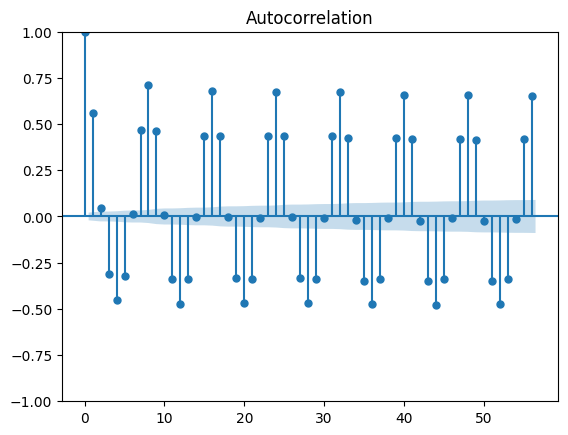

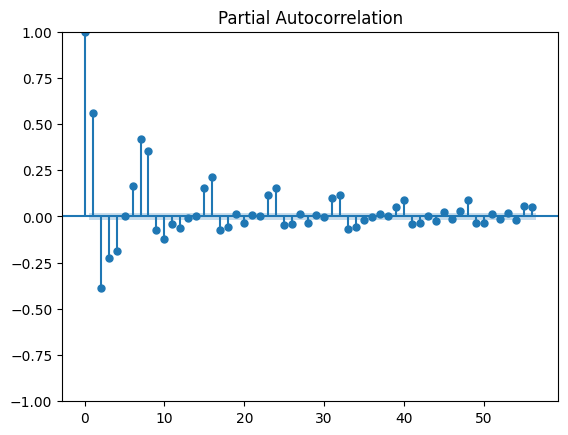

2025-05-09 13:33:29,445 - INFO - 
=== Model Training ===
2025-05-09 13:33:29,450 - INFO - SARIMAX Search Space:
2025-05-09 13:33:29,457 - INFO - Seasonality (m): 8
2025-05-09 13:33:29,484 - INFO - p range: 0-3, q range: 0-3
2025-05-09 13:33:29,490 - INFO - P range: 0-2, Q range: 0-2
2025-05-09 13:33:29,505 - INFO - d: 0, D: 0
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all


Starting model training...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[8] intercept   : AIC=40965.028, Time=3.09 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[8] intercept   : AIC=39271.931, Time=13.80 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[8] intercept   : AIC=39452.548, Time=13.30 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[8]             : AIC=41320.544, Time=3.23 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[8] intercept   : AIC=39628.553, Time=4.56 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[8] intercept   : AIC=39153.954, Time=25.31 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[8] intercept   : AIC=38946.954, Time=43.72 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[8] intercept   : AIC=38954.740, Time=21.81 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,2)[8] intercept   : AIC=38948.917, Time=66.80 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[8] intercept   : AIC=38947.044, Time=41.16 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,1)[8] intercept   : AIC=39980.609, Time=25.72 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[8] intercept   : AIC=38948.697, Time=52.53 sec


/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [62]:
# --- Logging Setup ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('sarimax_analysis.log'),
        logging.StreamHandler()
    ]
)

def log_dataframe_info(df, name):
    """Log basic dataframe information"""
    logging.info(f"\n{name} Information:")
    logging.info(f"Shape: {df.shape}")
    logging.info(f"Columns: {list(df.columns)}")
    logging.info(f"Missing Values:\n{df.isnull().sum()}")

def calculate_vif(X, threshold=5, whitelist=None):
    """Calculate VIF and remove problematic features"""
    
    if whitelist is None:
        whitelist = []
    
    X_with_const = X.copy()
    X_with_const['const'] = 1
    
    vif = pd.DataFrame()
    vif["Variable"] = X_with_const.columns
    vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                 for i in range(X_with_const.shape[1])]
    
    vif = vif[~vif['Variable'].isin(['const'] + whitelist)]
    high_vif = vif[vif.VIF > threshold]
    
    logging.info("\nVIF Analysis:")
    logging.info(f"VIF Threshold: {threshold}")
    logging.info(f"Initial Features:\n{vif.sort_values('VIF', ascending=False).to_string()}")
    logging.info(f"whitelist{whitelist}")
    
    removed = []
    while not high_vif.empty:
        candidates = high_vif[~high_vif['Variable'].isin(whitelist)]
        if candidates.empty:
            logging.info('Only whitelist items with high vif available - abort...')
            break
        worst_feature = high_vif.sort_values('VIF', ascending=False).iloc[0]['Variable']
        X = X.drop(columns=[worst_feature])
        removed.append(worst_feature)
        
        if X.empty:
            break
            
        X_with_const = X.copy()
        X_with_const['const'] = 1
        vif = pd.DataFrame({
            "Variable": X.columns,
            "VIF": [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(len(X.columns))]
        })
        high_vif = vif[vif.VIF > threshold]
    
    logging.info(f"\nRemoved features due to high VIF: {removed}")
    logging.info(f"Final Features:\n{vif.sort_values('VIF', ascending=False).to_string()}")
    
    return X, removed

# --- Data Preparation (3-Hour Intervals) ---
def prepare_data(df, start_date, end_date):
    """Cleans and transforms data with logging"""
    logging.info("\n=== Data Preparation ===")
    df = df.loc[start_date:end_date].resample('3h').mean()
    numeric_cols = df.select_dtypes(np.float64).columns
    df[numeric_cols] = df[numeric_cols].astype(np.float32)
    df = df[['co2_flux_filled']].copy()
    log_dataframe_info(df, "Initial Data")
    return df.dropna()

def create_fourier_terms(dates):
    """Fourier terms for 3-hour intervals and annual seasonality"""
    fourier_terms = pd.DataFrame(index=dates)
    
    # Daily seasonality (8 periods per day)
    hours = dates.hour
    fourier_terms['cos_daily_1'] = np.cos(2 * np.pi * (hours/3) / 8)
    fourier_terms['sin_daily_1'] = np.sin(2 * np.pi * (hours/3) / 8)
    fourier_terms['cos_daily_2'] = np.cos(4 * np.pi * (hours/3) / 8)
    fourier_terms['sin_daily_2'] = np.sin(4 * np.pi * (hours/3) / 8)

    # Annual seasonality
    dayofyear = dates.dayofyear
    fourier_terms['cos_yearly_1'] = np.cos(2 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_1'] = np.sin(2 * np.pi * dayofyear / 365.25)
    fourier_terms['cos_yearly_2'] = np.cos(4 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_2'] = np.sin(4 * np.pi * dayofyear / 365.25)

    return fourier_terms

def determine_day_night(df, sw_in_threshold=0):
    """Night Identifier"""
    df['is_night'] = (df['SW_IN'] < sw_in_threshold).astype(np.int8)
    return df

def interpolate_features(df, columns, method='linear', limit=8):
    """Interpolation for 3-hour data"""
    for col in columns:
        if col in df.columns:
            df[col] = df[col].interpolate(method=method, limit=limit, limit_direction='both')
    return df

def standardize_features(df, columns):
    """Standardization"""
    for col in columns:
        if col in df.columns:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

# --- Differencing ---
def determine_differencing(y):
    """Optimal Differencing"""
    d = ndiffs(y, test='adf', max_d=2)
    D = nsdiffs(y, m=8, test='ocsb', max_D=1)  # 8 periods per day
    print(f"Differencing: d={d}, D={D}")
    return d, D

def analyze_seasonality(y, lags=56):  # 7 days for 3-hour intervals
    """Seasonality Analysis"""
    plot_acf(y, lags=lags, alpha=0.05)
    plt.show()
    plot_pacf(y, lags=lags, alpha=0.05)
    plt.show()

# --- Main Workflow ---
# 1. Load Data
logging.info("\n=== Starting Analysis ===")
df = prepare_data(flux_df, '2018-01-01', '2021-12-31')

# 2. Add Meteorological Data
logging.info("\n=== Adding Meteorological Data ===")
meteo_data = meteorology[['TA_1_1_1', 'SW_IN_1_1_1']].resample('3h').mean()
meteo_data.columns = ['TA', 'SW_IN']
df = pd.merge(df, meteo_data, left_index=True, right_index=True, how='left')
df = interpolate_features(df, ['TA', 'SW_IN'])
df = standardize_features(df, ['TA', 'SW_IN'])
df = determine_day_night(df)

# 3. Feature Engineering
logging.info("\n=== Feature Engineering ===")
df['TA_SWIN'] = df['TA'] * df['SW_IN']
df['TA_night'] = df['TA'] * df['is_night']
df['SW_IN_is_night'] = df['SW_IN'] * (1 - df['is_night'])
df = pd.concat([df, create_fourier_terms(df.index)], axis=1)
log_dataframe_info(df, "After Feature Engineering")

# 4. Multicollinearity Check
logging.info("\n=== Multicollinearity Check ===")
X = df.drop(columns=['co2_flux_filled'])
X_filtered, removed = calculate_vif(X, threshold=5, whitelist= ['SW_IN'])
df = pd.concat([df[['co2_flux_filled']], X_filtered], axis=1)

# 5. Train/Test Split
logging.info("\n=== Train/Test Split ===")
train_end = '2020-12-31'
train_data = df.loc[:train_end]
test_data = df.loc[train_end:]

y_train = train_data['co2_flux_filled']
X_train = train_data.drop(columns=['co2_flux_filled'])
y_test = test_data['co2_flux_filled']
X_test = test_data.drop(columns=['co2_flux_filled'])

# 6. Differencing
logging.info("\n=== Differencing ===")
d, D = determine_differencing(y_train)
analyze_seasonality(y_train)

# 7. Auto-ARIMA with Expanded Search Space
logging.info("\n=== Model Training ===")
logging.info(f"SARIMAX Search Space:")
logging.info(f"Seasonality (m): 8")
logging.info(f"p range: 0-3, q range: 0-3")
logging.info(f"P range: 0-2, Q range: 0-2")
logging.info(f"d: {d}, D: {D}")
print("\nStarting model training...")
auto_model = pm.auto_arima(
    y=y_train,
    X=X_train,
    seasonal=True,
    m=8,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=d, D=D,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=4,
    information_criterion='aic',
    random_state=42,
    maxiter=100
)

# 8. Model Analysis
logging.info("\n=== Final Model ===")
logging.info(f"SARIMAX{auto_model.order}x{auto_model.seasonal_order}")
logging.info("Model Parameters:")
for param, value in auto_model.params().items():
    logging.info(f"{param}: {value:.4f}")
print(f"\nOptimal Model: SARIMAX{auto_model.order}x{auto_model.seasonal_order}")
print(auto_model.summary())
auto_model.plot_diagnostics(figsize=(12, 10))
plt.show()

# 9. Forecast
forecast, conf_int = auto_model.predict(
    n_periods=len(test_data),
    X=X_test,
    return_conf_int=True,
    alpha=0.05
)

# 10. Evaluation
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Training')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, forecast, label='Forecast')
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('3-Hour Forecast')
plt.show()

print(f"MAE: {mean_absolute_error(y_test, forecast):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, forecast)):.4f}")

# 11. Feature Importance
if hasattr(auto_model, 'arima_res_') and hasattr(auto_model.arima_res_, 'pvalues'):
    # Correct access method for pvalues (without parentheses!)
    exog_pvalues = auto_model.arima_res_.pvalues
    
    # Index calculation for exogenous variables
    arima_params_count = len(auto_model.order) + len(auto_model.seasonal_order)
    if len(exog_pvalues) > arima_params_count:
        # Extract only the p-values of the exogenous variables
        exog_pvalues = exog_pvalues[arima_params_count:]
        exog_names = X_train.columns
        
        # Ensure that the count matches
        n_features = min(len(exog_names), len(exog_pvalues))
        feature_importance = pd.DataFrame({
            'Feature': exog_names[:n_features],
            'p-value': exog_pvalues[:n_features]
        }).sort_values('p-value')

        print("\nFeature Importance:")
        print(feature_importance)
        
        plt.figure(figsize=(10, 4))
        plt.barh(feature_importance['Feature'], -np.log10(feature_importance['p-value']))
        plt.title('Feature Importance (-log10 p-values)')
        plt.show()

# 13. Save the trained model *with its metadata*
logging.info("\n--- Saving trained SARIMAX bundle ---")

bundle = SarimaxBundle(
    model=auto_model,
    exog_order=list(X_train.columns),       # <–– exact order after VIF
    prep_kwargs={
        "start": "2015-01-01",
        "end":   "2023-12-31",
    },
)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
bundle_path = f"sarimax_bundle_test_{timestamp}.pkl"

joblib.dump(bundle, bundle_path)
logging.info(f"Bundle saved → {bundle_path}")
# 12. Cleanup & Save
del df, train_data, test_data
gc.collect()

## Train SARIMAX(2, 0, 1)x(2, 0, 1, 8) on whole dataset
because this model is the best in the previous analysis.

2025-05-09 13:40:05,092 - INFO - === Preparing Full Dataset ===
2025-05-09 13:40:05,344 - INFO - 
Prepared Dataset Information:
2025-05-09 13:40:05,344 - INFO - Shape: (26296, 15)
2025-05-09 13:40:05,345 - INFO - Columns: ['co2_flux_filled', 'TA', 'SW_IN', 'is_night', 'TA_SWIN', 'TA_night', 'SW_IN_is_night', 'cos_daily_1', 'sin_daily_1', 'cos_daily_2', 'sin_daily_2', 'cos_yearly_1', 'sin_yearly_1', 'cos_yearly_2', 'sin_yearly_2']
2025-05-09 13:40:05,347 - INFO - Missing Values:
co2_flux_filled    0
TA                 0
SW_IN              0
is_night           0
TA_SWIN            0
TA_night           0
SW_IN_is_night     0
cos_daily_1        0
sin_daily_1        0
cos_daily_2        0
sin_daily_2        0
cos_yearly_1       0
sin_yearly_1       0
cos_yearly_2       0
sin_yearly_2       0
dtype: int64
2025-05-09 13:40:05,350 - INFO - === Training Fixed SARIMAX(2,0,1)x(2,0,1,8) Model ===
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: Co

                                     SARIMAX Results                                     
Dep. Variable:                   co2_flux_filled   No. Observations:                21036
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 8)   Log Likelihood              -47157.795
Date:                           Fri, 09 May 2025   AIC                          94357.590
Time:                                   13:42:03   BIC                          94524.606
Sample:                               01-01-2015   HQIC                         94412.101
                                    - 03-14-2022                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
TA                -0.0135      0.071     -0.191      0.849      -0.152       0.125
SW_IN             -3.6829      

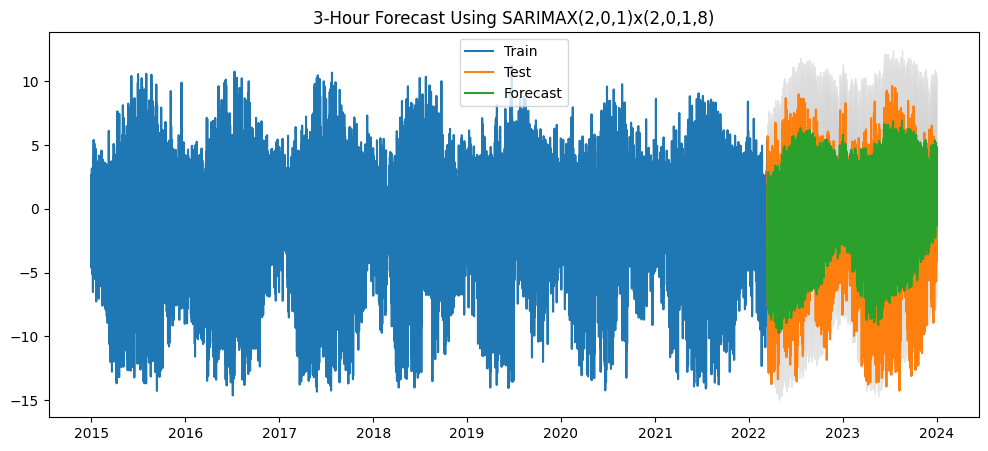

2025-05-09 13:42:04,174 - INFO - 
--- Saving trained SARIMAX bundle ---



MAE: 2.5126
RMSE: 3.2678


2025-05-09 13:42:07,951 - INFO - Bundle saved → sarimax_bundle_20250509_134204.pkl


In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import logging
import gc
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Logging Setup ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('sarimax_fixed_model.log'),
        logging.StreamHandler()
    ]
)

# --- Helper Functions ---
def log_dataframe_info(df, name):
    logging.info(f"\n{name} Information:")
    logging.info(f"Shape: {df.shape}")
    logging.info(f"Columns: {list(df.columns)}")
    logging.info(f"Missing Values:\n{df.isnull().sum()}")

def create_fourier_terms(dates):
    fourier_terms = pd.DataFrame(index=dates)
    hours = dates.hour
    fourier_terms['cos_daily_1'] = np.cos(2 * np.pi * (hours/3) / 8)
    fourier_terms['sin_daily_1'] = np.sin(2 * np.pi * (hours/3) / 8)
    fourier_terms['cos_daily_2'] = np.cos(4 * np.pi * (hours/3) / 8)
    fourier_terms['sin_daily_2'] = np.sin(4 * np.pi * (hours/3) / 8)

    dayofyear = dates.dayofyear
    fourier_terms['cos_yearly_1'] = np.cos(2 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_1'] = np.sin(2 * np.pi * dayofyear / 365.25)
    fourier_terms['cos_yearly_2'] = np.cos(4 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_2'] = np.sin(4 * np.pi * dayofyear / 365.25)

    return fourier_terms

def standardize_features(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

def interpolate_features(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].interpolate(method='linear', limit=8, limit_direction='both')
    return df

# --- Prepare Data ---
logging.info("=== Preparing Full Dataset ===")
df = flux_df.resample('3h').mean()
df = df[['co2_flux_filled']].copy()

meteo_data = meteorology[['TA_1_1_1', 'SW_IN_1_1_1']].resample('3h').mean()
meteo_data.columns = ['TA', 'SW_IN']
df = pd.merge(df, meteo_data, left_index=True, right_index=True, how='left')

df = interpolate_features(df, ['TA', 'SW_IN'])
df = standardize_features(df, ['TA', 'SW_IN'])
df['is_night'] = (df['SW_IN'] < 0).astype(np.int8)
df['TA_SWIN'] = df['TA'] * df['SW_IN']
df['TA_night'] = df['TA'] * df['is_night']
df['SW_IN_is_night'] = df['SW_IN'] * (1 - df['is_night'])

fourier = create_fourier_terms(df.index)
df = pd.concat([df, fourier], axis=1)
df = df.dropna()
log_dataframe_info(df, "Prepared Dataset")

# --- Train/Test Split (80/20) ---
split_index = int(len(df) * 0.8)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

y_train = train_data['co2_flux_filled']
X_train = train_data.drop(columns=['co2_flux_filled'])
y_test = test_data['co2_flux_filled']
X_test = test_data.drop(columns=['co2_flux_filled'])

# --- Train SARIMAX Model ---
logging.info("=== Training Fixed SARIMAX(2,0,1)x(2,0,1,8) Model ===")
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2, 0, 1),
    seasonal_order=(2, 0, 1, 8),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

logging.info(f"Model Summary:\n{results.summary()}")
print(results.summary())

# --- Forecast ---
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

# --- Plot Forecast ---
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, pred_mean, label='Forecast')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('3-Hour Forecast Using SARIMAX(2,0,1)x(2,0,1,8)')
plt.show()

# --- Evaluation ---
mae = mean_absolute_error(y_test, pred_mean)
rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
print(f"\nMAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")






### Another small test but with updated model

2025-05-09 13:58:43,783 - INFO - === Daten vorbereiten ===
2025-05-09 13:58:43,825 - INFO - 
Prepared Dataset Information:
2025-05-09 13:58:43,825 - INFO - Shape: (26296, 15)
2025-05-09 13:58:43,826 - INFO - Columns: ['co2_flux_filled', 'TA', 'SW_IN', 'is_night', 'TA_SWIN', 'TA_night', 'SW_IN_is_night', 'cos_daily_1', 'sin_daily_1', 'cos_daily_2', 'sin_daily_2', 'cos_yearly_1', 'sin_yearly_1', 'cos_yearly_2', 'sin_yearly_2']
2025-05-09 13:58:43,827 - INFO - Missing Values:
co2_flux_filled    0
TA                 0
SW_IN              0
is_night           0
TA_SWIN            0
TA_night           0
SW_IN_is_night     0
cos_daily_1        0
sin_daily_1        0
cos_daily_2        0
sin_daily_2        0
cos_yearly_1       0
sin_yearly_1       0
cos_yearly_2       0
sin_yearly_2       0
dtype: int64
2025-05-09 13:58:43,829 - INFO - === Training Fixed SARIMAX(2,0,1)x(2,0,1,8) Model ===
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: Converg

                                     SARIMAX Results                                     
Dep. Variable:                   co2_flux_filled   No. Observations:                21036
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 8)   Log Likelihood              -47203.401
Date:                           Fri, 09 May 2025   AIC                          94448.801
Time:                                   14:00:40   BIC                          94615.817
Sample:                               01-01-2015   HQIC                         94503.313
                                    - 03-14-2022                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
TA                -0.2243      0.070     -3.184      0.001      -0.362      -0.086
SW_IN             -3.4611      

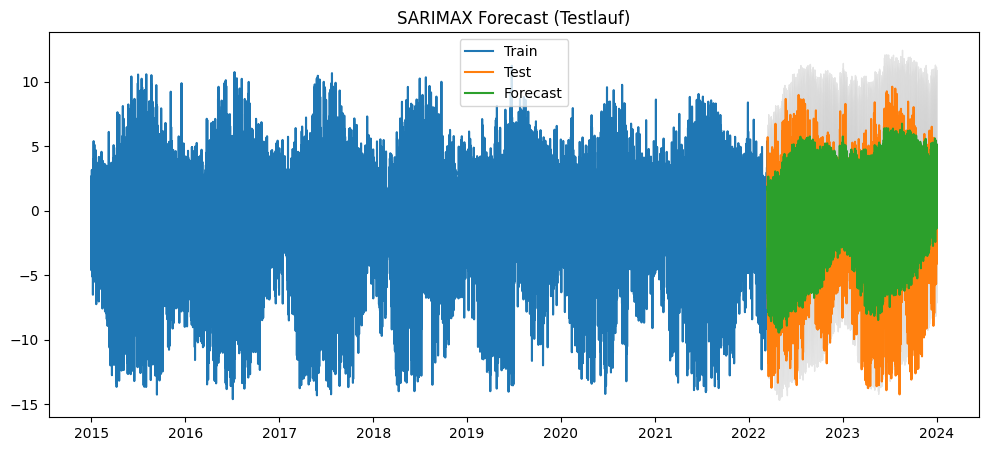


MAE: 2.5558
RMSE: 3.2992
R²: 0.4789


2025-05-09 14:00:42,009 - INFO - Testmodell gespeichert unter: sarimax_testbundle_20250509_140040.pkl


4480

In [74]:
import pandas as pd
import numpy as np
import logging
import gc
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
import joblib
import datetime

# --- Logging Setup ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('sarimax_test_run.log'),
        logging.StreamHandler()
    ]
)

# --- Helper Functions ---
def log_dataframe_info(df, name):
    logging.info(f"\n{name} Information:")
    logging.info(f"Shape: {df.shape}")
    logging.info(f"Columns: {list(df.columns)}")
    logging.info(f"Missing Values:\n{df.isnull().sum()}")

def create_fourier_terms(dates):
    fourier_terms = pd.DataFrame(index=dates)
    hours = dates.hour
    fourier_terms['cos_daily_1'] = np.cos(2 * np.pi * (hours / 3) / 8)
    fourier_terms['sin_daily_1'] = np.sin(2 * np.pi * (hours / 3) / 8)
    fourier_terms['cos_daily_2'] = np.cos(4 * np.pi * (hours / 3) / 8)
    fourier_terms['sin_daily_2'] = np.sin(4 * np.pi * (hours / 3) / 8)
    dayofyear = dates.dayofyear
    fourier_terms['cos_yearly_1'] = np.cos(2 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_1'] = np.sin(2 * np.pi * dayofyear / 365.25)
    fourier_terms['cos_yearly_2'] = np.cos(4 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_2'] = np.sin(4 * np.pi * dayofyear / 365.25)
    return fourier_terms

def standardize_features(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

def determine_day_night(df, sw_in_threshold=0):
    df['is_night'] = (df['SW_IN'] < sw_in_threshold).astype(np.int8)
    return df

# --- Datenvorbereitung ---
logging.info("=== Daten vorbereiten ===")
df = flux_df.loc['2015-01-01':'2023-12-31'].resample('3h').mean()
df = df[['co2_flux_filled']].copy()

meteo_data = flux_df[['TA_1_1_1', 'SW_IN']].resample('3h').mean()
meteo_data.columns = ['TA', 'SW_IN']
df = pd.merge(df, meteo_data, left_index=True, right_index=True, how='left')

# Features interpolieren & normalisieren
df = df.interpolate(limit_direction='both')
df = standardize_features(df, ['TA', 'SW_IN'])

# Feature Engineering
df = determine_day_night(df)
df['TA_SWIN'] = df['TA'] * df['SW_IN']
df['TA_night'] = df['TA'] * df['is_night']
df['SW_IN_is_night'] = df['SW_IN'] * (1 - df['is_night'])

# Fourier-Features
fourier = create_fourier_terms(df.index)
df = pd.concat([df, fourier], axis=1)
df = df.dropna()

log_dataframe_info(df, "Prepared Dataset")

# --- Train/Test Split ---
split_index = int(len(df) * 0.8)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

y_train = train_data['co2_flux_filled']
X_train = train_data.drop(columns=['co2_flux_filled'])
y_test = test_data['co2_flux_filled']
X_test = test_data.drop(columns=['co2_flux_filled'])

# --- Modelltraining (SARIMAX fest) ---
logging.info("=== Training Fixed SARIMAX(2,0,1)x(2,0,1,8) Model ===")
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2, 0, 1),
    seasonal_order=(2, 0, 1, 8),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print(results.summary())

# --- Forecasting ---
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, pred_mean, label='Forecast')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('SARIMAX Forecast (Testlauf)')
plt.show()

# --- Evaluation ---
mae = mean_absolute_error(y_test, pred_mean)
rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
r2 = r2_score(y_test, pred_mean)

print(f"\nMAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")



bundle = SarimaxBundle(
    model      = results,
    exog_order = list(X_train.columns)
)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
bundle_path = f"sarimax_testbundle_{timestamp}.pkl"
joblib.dump(bundle, bundle_path)
logging.info(f"Testmodell gespeichert unter: {bundle_path}")

# --- Cleanup ---
del df, train_data, test_data
gc.collect()


=== Extended Evaluation Metrics ===
MSE                    10.8847
RMSE                    3.2992
NRMSE                   0.1381
MAE                     2.5558
MedAE                   2.0784
R²                      0.4789
Explained Variance      0.6388
MBE (Bias)             -1.8274
Pearson R               0.8021
MAPE (%)              305.7786
sMAPE (%)              83.0665
dtype: float64

=== Daytime Performance ===
RMSE          3.5634
MAE           2.9170
R²           -0.0032
MAPE (%)    109.7000
dtype: float64

=== Nighttime Performance ===
RMSE          3.1669
MAE           2.3854
R²           -0.1593
MAPE (%)    398.2768
dtype: float64


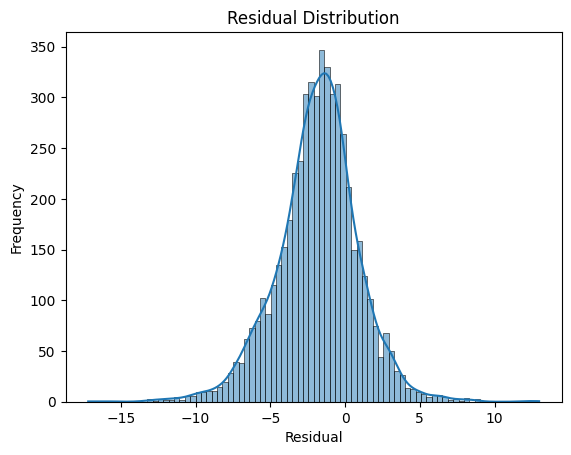

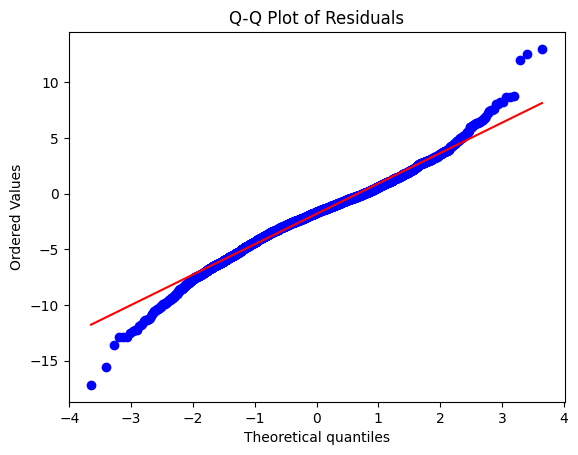

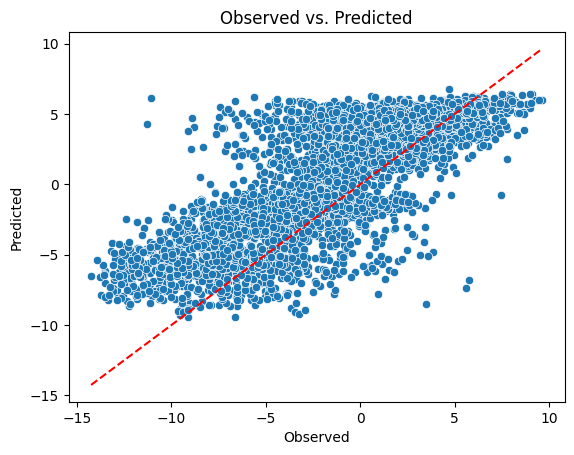

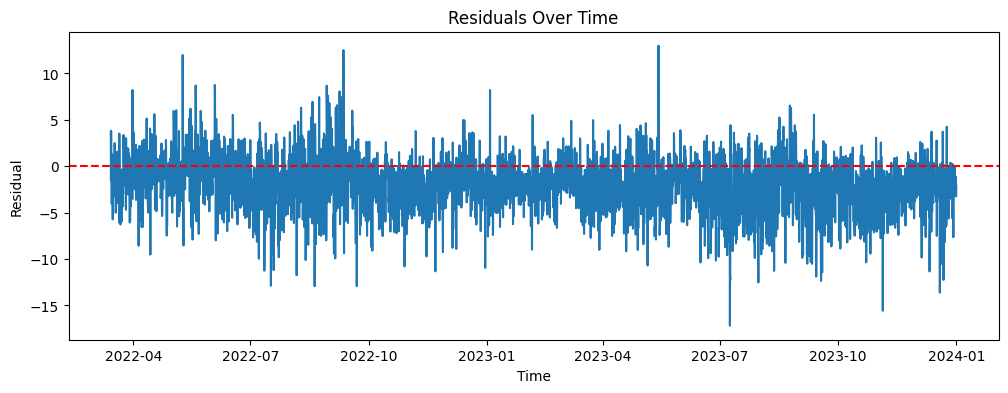


=== SARIMAX Exogenous Feature Coefficients ===
TA               -0.2243
SW_IN            -3.4611
is_night          1.1050
TA_SWIN           0.3235
TA_night          1.3705
SW_IN_is_night    1.9614
cos_daily_1       2.3301
sin_daily_1      -0.7430
cos_daily_2      -0.4820
sin_daily_2       0.5770
cos_yearly_1      0.1259
sin_yearly_1     -0.1429
cos_yearly_2      0.2491
sin_yearly_2      0.0869
dtype: float64


In [86]:
# --- Extended Evaluation ---
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    explained_variance_score,
    mean_absolute_percentage_error
)
from scipy.stats import pearsonr, probplot
import seaborn as sns

# Compute residuals
residuals = y_test - pred_mean

# Calculate metrics
mse = mean_squared_error(y_test, pred_mean)
rmse = np.sqrt(mse)
nrmse = rmse / (y_test.max() - y_test.min())
mae = mean_absolute_error(y_test, pred_mean)
medae = median_absolute_error(y_test, pred_mean)
r2 = r2_score(y_test, pred_mean)
expl_var = explained_variance_score(y_test, pred_mean)
mbe = residuals.mean()
r, _ = pearsonr(y_test, pred_mean)
mape = mean_absolute_percentage_error(y_test, pred_mean)
smape = 100 * np.mean(2 * np.abs(pred_mean - y_test) / (np.abs(pred_mean) + np.abs(y_test)))

# Summary
metrics = pd.Series({
    "MSE": mse,
    "RMSE": rmse,
    "NRMSE": nrmse,
    "MAE": mae,
    "MedAE": medae,
    "R²": r2,
    "Explained Variance": expl_var,
    "MBE (Bias)": mbe,
    "Pearson R": r,
    "MAPE (%)": mape * 100,
    "sMAPE (%)": smape
})

print("\n=== Extended Evaluation Metrics ===")
print(metrics.round(4))

# Restore day/night labels if needed
X_test_with_night = X_test.copy()
X_test_with_night['is_night'] = X_test['is_night'] if 'is_night' in X_test else determine_day_night(X_test).is_night

eval_df = y_test.to_frame(name='y_true')
eval_df['yhat'] = pred_mean.values
eval_df['resid'] = residuals.values
eval_df['is_night'] = X_test_with_night['is_night'].values

def calc_submetrics(df):
    return {
        "RMSE": np.sqrt(mean_squared_error(df.y_true, df.yhat)),
        "MAE": mean_absolute_error(df.y_true, df.yhat),
        "R²": r2_score(df.y_true, df.yhat),
        "MAPE (%)": mean_absolute_percentage_error(df.y_true, df.yhat) * 100
    }

print("\n=== Daytime Performance ===")
print(pd.Series(calc_submetrics(eval_df[eval_df['is_night'] == 0])).round(4))

print("\n=== Nighttime Performance ===")
print(pd.Series(calc_submetrics(eval_df[eval_df['is_night'] == 1])).round(4))

# Residuals Histogram
plt.figure()
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
plt.figure()
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Actual vs. Predicted
plt.figure()
sns.scatterplot(x=y_test, y=pred_mean)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs. Predicted")
plt.show()

# Residuals Over Time
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()

print("\n=== SARIMAX Exogenous Feature Coefficients ===")
coefs = pd.Series(results.params)
print(coefs[X_train.columns].round(4))

In [17]:
from sklearn.metrics import r2_score

# Calculate predictions on the test set
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
pred_mean = forecast.predicted_mean

# Calculate R²
r2 = r2_score(y_test, pred_mean)
print(f"R² Score: {r2:.4f}")

NameError: name 'results' is not defined

## Feature Engineering

In [6]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import gc
import warnings
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import MissingDataError
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs, nsdiffs

# ---------------------------
# Logging Configuration
# ---------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = f"sarimax_features_{timestamp}.log"
# Remove any existing handlers (prevents duplicate logs in Jupyter)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_filename),
        logging.StreamHandler()
    ]
)

warnings.filterwarnings("ignore", category=FutureWarning)

# ---------------------------
# Helper Functions
# ---------------------------
def calculate_vif(X, threshold=5, whitelist=None):
    if whitelist is None:
        whitelist = []
    X_with_const = X.copy()
    X_with_const['const'] = 1
    vif = pd.DataFrame()
    vif["Variable"] = X_with_const.columns
    vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    vif = vif[~vif['Variable'].isin(['const'] + whitelist)]
    high_vif = vif[vif.VIF > threshold]
    logging.info("\nVIF Analysis:")
    logging.info(f"VIF Threshold: {threshold}")
    logging.info(f"Initial Features:\n{vif.sort_values('VIF', ascending=False).to_string()}")
    removed = []
    while not high_vif.empty:
        candidates = high_vif[~high_vif['Variable'].isin(whitelist)]
        if candidates.empty:
            logging.info('Only whitelist items with high vif available - abort...')
            break
        worst_feature = high_vif.sort_values('VIF', ascending=False).iloc[0]['Variable']
        X = X.drop(columns=[worst_feature])
        removed.append(worst_feature)
        if X.empty:
            break
        X_with_const = X.copy()
        X_with_const['const'] = 1
        vif = pd.DataFrame({
            "Variable": X.columns,
            "VIF": [variance_inflation_factor(X_with_const.values, i) for i in range(len(X.columns))]
        })
        high_vif = vif[vif.VIF > threshold]
    logging.info(f"\nRemoved features due to high VIF: {removed}")
    logging.info(f"Final Features:\n{vif.sort_values('VIF', ascending=False).to_string()}")
    return X, removed

def determine_differencing(y):
    d = ndiffs(y, test='adf', max_d=2)
    D = nsdiffs(y, m=8, test='ocsb', max_D=1)
    logging.info(f"Differencing: d={d}, D={D}")
    return d, D

def standardize_features(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

def create_fourier_terms(dates):
    fourier_terms = pd.DataFrame(index=dates)
    hours = dates.hour
    fourier_terms['cos_daily_1'] = np.cos(2 * np.pi * (hours / 3) / 8)
    fourier_terms['sin_daily_1'] = np.sin(2 * np.pi * (hours / 3) / 8)
    fourier_terms['cos_daily_2'] = np.cos(4 * np.pi * (hours / 3) / 8)
    fourier_terms['sin_daily_2'] = np.sin(4 * np.pi * (hours / 3) / 8)
    dayofyear = dates.dayofyear
    fourier_terms['cos_yearly_1'] = np.cos(2 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_1'] = np.sin(2 * np.pi * dayofyear / 365.25)
    fourier_terms['cos_yearly_2'] = np.cos(4 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_2'] = np.sin(4 * np.pi * dayofyear / 365.25)
    return fourier_terms

def determine_day_night(df, sw_in_threshold=0):
    df['is_night'] = (df['SW_IN'] < sw_in_threshold).astype(np.int8)
    return df

def feature_engineering(df, selected_features):
    df = determine_day_night(df)
    if 'TA_SWIN' in selected_features:
        df['TA_SWIN'] = df['TA'] * df['SW_IN']
    if 'TA_night' in selected_features:
        df['TA_night'] = df['TA'] * df['is_night']
    if 'SW_IN_is_night' in selected_features:
        df['SW_IN_is_night'] = df['SW_IN'] * (1 - df['is_night'])
    fourier_cols = [f for f in selected_features if f.startswith('cos_') or f.startswith('sin_')]
    if fourier_cols:
        df = pd.concat([df, create_fourier_terms(df.index)[fourier_cols]], axis=1)
    return df

# ---------------------------
# Parameters & Base Dataset
# ---------------------------
start_date = "2015-01-01"
end_date = "2023-12-31"

all_data = flux_df.loc[start_date:end_date].resample('3h').mean()
df_base = all_data[['co2_flux_filled']].copy()
df_base['TA'] = all_data['TA_1_1_1']
df_base['SW_IN'] = all_data['SW_IN']
df_base['TS_1_1_1'] = all_data['TS_1_1_1']

# ---------------------------
# Feature Sets to Evaluate
# ---------------------------
feature_sets = [
    # ['TA', 'SW_IN'],
    # ['TA', 'SW_IN', 'TS_1_1_1'],
    # ['TA', 'SW_IN', 'TA_SWIN'],
    # ['TA', 'SW_IN', 'TA_night'],
    # ['TA', 'SW_IN', 'SW_IN_is_night'],
    # ['TA', 'SW_IN', 'cos_daily_1', 'sin_daily_1'],
    # ['TA', 'SW_IN', 'cos_yearly_1', 'sin_yearly_1'],
    ['TA', 'SW_IN', 'TA_SWIN', 'SW_IN_is_night', 'cos_daily_1', 'sin_daily_1', 'cos_yearly_1', 'sin_yearly_1'],
[
    'TA_SWIN', 'TA_night', 'SW_IN_is_night',
    'cos_daily_1', 'sin_daily_1', 'cos_daily_2', 'sin_daily_2',
    'cos_yearly_1', 'sin_yearly_1', 'cos_yearly_2', 'sin_yearly_2',
    'is_night'
]

]

# ---------------------------
# SARIMAX Evaluation Loop
# ---------------------------
for i, feature_set in enumerate(feature_sets):
    logging.info(f"\n--- Running SARIMAX with Feature Set {i+1}: {feature_set} ---")
    df = df_base.copy()
    df = standardize_features(df, ['TA', 'SW_IN', 'TS_1_1_1'])
    df = feature_engineering(df, feature_set)
    df = df.dropna()

    y = df['co2_flux_filled']
    X = df.drop(columns=['co2_flux_filled'])
    X, _ = calculate_vif(X, threshold=5, whitelist=['SW_IN'])
    df = pd.concat([y, X], axis=1)

    train_size = int(0.8 * len(df))
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]

    y_train = train['co2_flux_filled']
    X_train = train.drop(columns=['co2_flux_filled'])
    y_test = test['co2_flux_filled']
    X_test = test.drop(columns=['co2_flux_filled'])

    d, D = determine_differencing(y_train)

    model = pm.auto_arima(
        y=y_train,
        X=X_train,
        seasonal=True,
        m=8,
        d=d,
        D=D,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        maxiter=100,
        n_jobs=1,
        ensure_all_finite=True
    )

    forecast = model.predict(n_periods=len(y_test), X=X_test)

    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    r2 = r2_score(y_test, forecast)

    logging.info(f"Evaluation Metrics for Feature Set {i+1}:")
    logging.info(f"MAE: {mae:.4f}")
    logging.info(f"RMSE: {rmse:.4f}")
    logging.info(f"R²: {r2:.4f}")

    gc.collect()

2025-05-10 10:05:17,479 - INFO - 
--- Running SARIMAX with Feature Set 1: ['TA', 'SW_IN', 'TA_SWIN', 'SW_IN_is_night', 'cos_daily_1', 'sin_daily_1', 'cos_yearly_1', 'sin_yearly_1'] ---
2025-05-10 10:05:17,630 - INFO - 
VIF Analysis:
2025-05-10 10:05:17,632 - INFO - VIF Threshold: 5
2025-05-10 10:05:17,638 - INFO - Initial Features:
         Variable        VIF
5  SW_IN_is_night  78.391532
2        TS_1_1_1  19.881141
8    cos_yearly_1   9.268186
0              TA   7.941123
3        is_night   6.638702
6     cos_daily_1   3.783624
4         TA_SWIN   2.466121
9    sin_yearly_1   2.440908
7     sin_daily_1   1.625117
2025-05-10 10:05:17,789 - INFO - Only whitelist items with high vif available - abort...
2025-05-10 10:05:17,791 - INFO - 
Removed features due to high VIF: ['SW_IN_is_night', 'TS_1_1_1']
2025-05-10 10:05:17,793 - INFO - Final Features:
       Variable       VIF
1         SW_IN  7.780349
2      is_night  4.137450
0            TA  3.538921
6  cos_yearly_1  2.894985
3       T

## Analyze the whole dataset with auto_arima

2025-05-09 18:45:00,711 - INFO - 
=== Starting Analysis ===
2025-05-09 18:45:00,711 - INFO - 
=== NaN Analysis BEFORE Resampling ===
2025-05-09 18:45:00,712 - INFO - Total datapoints before resampling: 157776
2025-05-09 18:45:00,789 - INFO - Total NaN values before resampling: 68139
2025-05-09 18:45:00,795 - INFO - NaN count per column before resampling:
Tau                      0
qc_Tau                   0
H                        0
qc_H                     0
qc_LE                    0
co2_flux             27557
qc_co2_flux              0
h2o_flux                 0
qc_h2o_flux              0
co2_mole_fraction        0
h2o_mole_fraction        0
u*                       0
L                        0
u_var                    0
v_var                    0
w_var                    0
ts_var                   0
LE                       0
SW_IN                    0
co2_flux_clean       40582
co2_flux_lin             0
co2_flux_filled          0
TA_1_1_1                 0
RH_1_1_1              


=== Preflight Diagnostics: Day/Night Related Features ===

1. Distribution of 'is_night':
is_night
1    0.7005
0    0.2995
Name: relative_frequency, dtype: float64

2. No constant or near-constant features detected.

3. NaN and Inf check:
No NaN values detected.
No infinite values detected.

Preflight check complete.



2025-05-09 18:45:01,125 - INFO - 
VIF Analysis:
2025-05-09 18:45:01,127 - INFO - VIF Threshold: 5
2025-05-09 18:45:01,130 - INFO - Initial Features:
          Variable        VIF
6   SW_IN_is_night  79.113188
2         TS_1_1_1  20.141204
0               TA  17.132126
5         TA_night   9.957468
11    cos_yearly_1   9.438930
3         is_night   7.070197
4          TA_SWIN   6.868015
7      cos_daily_1   4.000358
12    sin_yearly_1   2.489939
8      sin_daily_1   1.686622
10     sin_daily_2   1.146752
13    cos_yearly_2   1.082506
9      cos_daily_2   1.065165
14    sin_yearly_2   1.017541
2025-05-09 18:45:01,131 - INFO - whitelist: ['SW_IN']
2025-05-09 18:45:01,685 - INFO - Only whitelist items with high vif available - abort...
2025-05-09 18:45:01,687 - INFO - 
Removed features due to high VIF: ['SW_IN_is_night', 'TS_1_1_1', 'TA']
2025-05-09 18:45:01,690 - INFO - Final Features:
        Variable       VIF
0          SW_IN  9.257662
1       is_night  4.334474
2        TA_SWIN  3.547

Differencing: d=0, D=0


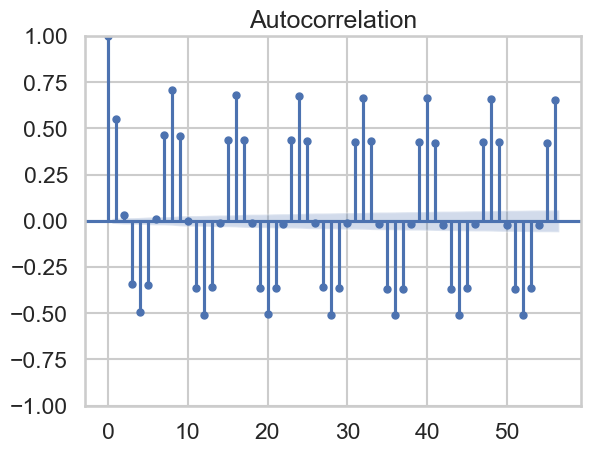

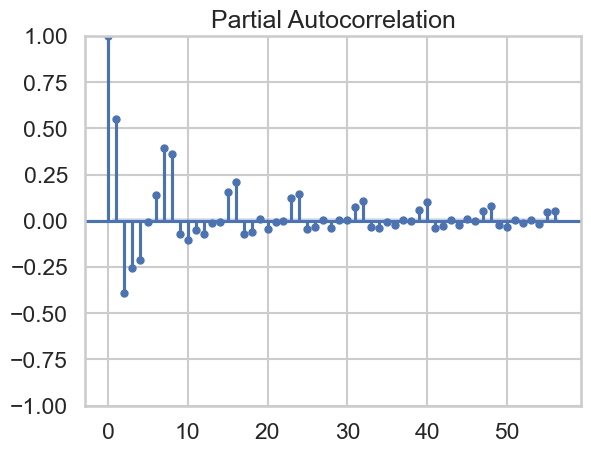

2025-05-09 18:45:02,303 - INFO - 
=== Model Training ===
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [116]:

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('sarimax_analysis.log'),
        logging.StreamHandler()
    ]
)

# --- Helper Functions ---
def log_dataframe_info(df, name):
    logging.info(f"\n{name} Information:")
    logging.info(f"Shape: {df.shape}")
    logging.info(f"Columns: {list(df.columns)}")
    logging.info(f"Missing Values:\n{df.isnull().sum()}")

def diagnose_day_night_features(df, threshold_var_std=1e-6):
    print("\n=== Preflight Diagnostics: Day/Night Related Features ===")

    if 'is_night' not in df.columns:
        print("Column 'is_night' not found. Skipping check.")
        return

    # 1. Distribution of is_night
    print("\n1. Distribution of 'is_night':")
    print(df['is_night'].value_counts(normalize=True).rename("relative_frequency").round(4))

    # 2. Check for constant or near-constant features
    critical_cols = ['is_night', 'TA_night', 'SW_IN_is_night']
    constant_like = {}
    for col in critical_cols:
        if col in df.columns:
            unique_vals = df[col].nunique()
            std_val = df[col].std()
            if unique_vals <= 1 or std_val < threshold_var_std:
                constant_like[col] = (unique_vals, std_val)

    if constant_like:
        print("\n2. Constant or near-constant features detected:")
        for col, (uniq, std) in constant_like.items():
            print(f"- {col}: unique_values={uniq}, std={std:.2e}")
        print("Recommendation: Remove these features or review their calculation logic.")
    else:
        print("\n2. No constant or near-constant features detected.")

    # 3. Check for missing or infinite values
    print("\n3. NaN and Inf check:")
    nan_cols = df.columns[df.isna().any()]
    inf_cols = df.columns[np.isinf(df).any()]
    if nan_cols.any():
        print("Columns containing NaN values:")
        for col in nan_cols:
            print(f"- {col}: {df[col].isna().sum()} missing")
    else:
        print("No NaN values detected.")

    if inf_cols.any():
        print("Columns containing infinite values:")
        for col in inf_cols:
            print(f"- {col}")
    else:
        print("No infinite values detected.")

    print("\nPreflight check complete.\n")

def calculate_vif(X, threshold=5, whitelist=None):
    if whitelist is None:
        whitelist = []
    X_with_const = X.copy()
    X_with_const['const'] = 1
    vif = pd.DataFrame()
    vif["Variable"] = X_with_const.columns
    vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    vif = vif[~vif['Variable'].isin(['const'] + whitelist)]
    high_vif = vif[vif.VIF > threshold]
    logging.info("\nVIF Analysis:")
    logging.info(f"VIF Threshold: {threshold}")
    logging.info(f"Initial Features:\n{vif.sort_values('VIF', ascending=False).to_string()}")
    logging.info(f"whitelist: {whitelist}")
    removed = []
    while not high_vif.empty:
        candidates = high_vif[~high_vif['Variable'].isin(whitelist)]
        if candidates.empty:
            logging.info('Only whitelist items with high vif available - abort...')
            break
        worst_feature = high_vif.sort_values('VIF', ascending=False).iloc[0]['Variable']
        X = X.drop(columns=[worst_feature])
        removed.append(worst_feature)
        if X.empty:
            break
        X_with_const = X.copy()
        X_with_const['const'] = 1
        vif = pd.DataFrame({
            "Variable": X.columns,
            "VIF": [variance_inflation_factor(X_with_const.values, i) for i in range(len(X.columns))]
        })
        high_vif = vif[vif.VIF > threshold]
    logging.info(f"\nRemoved features due to high VIF: {removed}")
    logging.info(f"Final Features:\n{vif.sort_values('VIF', ascending=False).to_string()}")
    return X, removed

def prepare_data(df, start_date, end_date):
    logging.info("\n=== Data Preparation ===")
    df = df.loc[start_date:end_date].copy()
    df_resampled = df.resample('3h').mean()
    nan_counts = df_resampled.isnull().sum()
    if nan_counts.sum() > 0:
        logging.warning(f"Unexpected NaN values after resampling:\n{nan_counts}")
    numeric_cols = df_resampled.select_dtypes(np.float64).columns
    df_resampled[numeric_cols] = df_resampled[numeric_cols].astype(np.float32)
    return df_resampled[['co2_flux_filled']]



def create_fourier_terms(dates):
    fourier_terms = pd.DataFrame(index=dates)
    hours = dates.hour
    fourier_terms['cos_daily_1'] = np.cos(2 * np.pi * (hours / 3) / 8)
    fourier_terms['sin_daily_1'] = np.sin(2 * np.pi * (hours / 3) / 8)
    fourier_terms['cos_daily_2'] = np.cos(4 * np.pi * (hours / 3) / 8)
    fourier_terms['sin_daily_2'] = np.sin(4 * np.pi * (hours / 3) / 8)
    dayofyear = dates.dayofyear
    fourier_terms['cos_yearly_1'] = np.cos(2 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_1'] = np.sin(2 * np.pi * dayofyear / 365.25)
    fourier_terms['cos_yearly_2'] = np.cos(4 * np.pi * dayofyear / 365.25)
    fourier_terms['sin_yearly_2'] = np.sin(4 * np.pi * dayofyear / 365.25)
    return fourier_terms

def determine_day_night(df, sw_in_threshold=0):
    df['is_night'] = (df['SW_IN'] < sw_in_threshold).astype(np.int8)
    return df

def standardize_features(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

def determine_differencing(y):
    d = ndiffs(y, test='adf', max_d=2)
    D = nsdiffs(y, m=8, test='ocsb', max_D=1)
    print(f"Differencing: d={d}, D={D}")
    return d, D

def analyze_seasonality(y, lags=56):
    plot_acf(y, lags=lags, alpha=0.05)
    plt.show()
    plot_pacf(y, lags=lags, alpha=0.05)
    plt.show()


def find_nan_sequences(series):
    """Find sequences of NaN values in a time series."""
    is_nan = series.isnull()
    if not is_nan.any():  # Wenn keine NaN-Werte vorhanden sind
        return []
        
    idx = np.flatnonzero(is_nan.values)
    if len(idx) == 0:  # Zusätzliche Sicherheitsprüfung
        return []
        
    sequences = np.split(idx, np.where(np.diff(idx) != 1)[0] + 1)
    return [(len(seq), series.index[seq[0]], series.index[seq[-1]]) for seq in sequences if len(seq) > 0]

# --- Main Workflow ---
logging.info("\n=== Starting Analysis ===")

logging.info("\n=== NaN Analysis BEFORE Resampling ===")
logging.info(f"Total datapoints before resampling: {len(flux_df)}")
total_nan_before = flux_df.isnull().sum().sum()
logging.info(f"Total NaN values before resampling: {total_nan_before}")
logging.info(f"NaN count per column before resampling:\n{flux_df.isnull().sum()}")

# Einmaliges Resampling für alle Daten
all_data = flux_df.loc['2015-01-01':'2023-12-31'].resample('3h').mean()
logging.info("\n=== NaN Analysis AFTER Resampling ===")
logging.info(f"Total datapoints after resampling: {len(all_data)}")
total_nan_after = all_data.isnull().sum().sum()
logging.info(f"Total NaN values after resampling: {total_nan_after}")
logging.info(f"NaN count per column after resampling:\n{all_data.isnull().sum()}")
# Aufteilen der Daten
df = all_data[['co2_flux_filled']].copy()
meteo_data = all_data[['TA_1_1_1', 'SW_IN']].copy()
meteo_data.columns = ['TA', 'SW_IN']
soil_data = all_data[['TS_1_1_1']].copy()

# Zusammenführen der Daten
df = pd.merge(df, meteo_data, left_index=True, right_index=True, how='left')
df = pd.merge(df, soil_data, left_index=True, right_index=True, how='left')

# Log-Info über mögliche NaN-Werte nach dem Merge
log_dataframe_info(df, "After Merging Data")

# Entfernen von NaN-Werten vor der Standardisierung
df = df.dropna()
logging.info("Shape after dropping NaN values: {}".format(df.shape))

# 3. Standardization
df = standardize_features(df, ['TA', 'SW_IN', 'TS_1_1_1'])

# Überprüfen auf inf/nan nach Standardisierung
inf_check = np.isinf(df).any().any()
nan_check = np.isnan(df).any().any()
if inf_check or nan_check:
    logging.warning("Found inf or nan values after standardization")
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    logging.info("Shape after cleaning inf/nan: {}".format(df.shape))

# 4. Feature Engineering
logging.info("\n=== Feature Engineering ===")
df = determine_day_night(df)
df['TA_SWIN'] = df['TA'] * df['SW_IN']
df['TA_night'] = df['TA'] * df['is_night']
df['SW_IN_is_night'] = df['SW_IN'] * (1 - df['is_night'])
df = pd.concat([df, create_fourier_terms(df.index)], axis=1)

# Überprüfen auf inf/nan nach Feature Engineering
inf_check = np.isinf(df).any().any()
nan_check = np.isnan(df).any().any()
if inf_check or nan_check:
    logging.warning("Found inf or nan values after feature engineering")
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    logging.info("Shape after cleaning inf/nan: {}".format(df.shape))

log_dataframe_info(df, "After Feature Engineering")

diagnose_day_night_features(df)

# 5. Multicollinearity Check
logging.info("\n=== Multicollinearity Check ===")
X = df.drop(columns=['co2_flux_filled'])

# Überprüfen auf inf/nan vor VIF
inf_check = np.isinf(X).any().any()
nan_check = np.isnan(X).any().any()
if inf_check or nan_check:
    logging.warning("Found inf or nan values before VIF calculation")
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna()
    logging.info("Shape after cleaning inf/nan: {}".format(X.shape))
    
X_filtered, removed = calculate_vif(X, threshold=5, whitelist=['SW_IN'])
df = pd.concat([df[['co2_flux_filled']], X_filtered], axis=1)

# 6. Train/Test Split (80/20)
logging.info("\n=== Train/Test Split ===")
train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

y_train = train_data['co2_flux_filled']
X_train = train_data.drop(columns=['co2_flux_filled'])
y_test = test_data['co2_flux_filled']
X_test = test_data.drop(columns=['co2_flux_filled'])

# 7. Differencing
logging.info("\n=== Differencing ===")
d, D = determine_differencing(y_train)
analyze_seasonality(y_train)

# 8. Auto-ARIMA
logging.info("\n=== Model Training ===")
auto_model = pm.auto_arima(
    y=y_train,
    X=X_train,
    seasonal=True,
    m=8,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=d, D=D,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=4,
    information_criterion='aic',
    random_state=42,
    maxiter=100
)

# 9. Model Analysis
print(auto_model.summary())
auto_model.plot_diagnostics(figsize=(12, 10))
plt.show()

# 10. Forecast
forecast, conf_int = auto_model.predict(
    n_periods=len(test_data),
    X=X_test,
    return_conf_int=True,
    alpha=0.05
)

# 11. Evaluation
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Training')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, forecast, label='Forecast')
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('3-Hour Forecast')
plt.show()

print(f"MAE: {mean_absolute_error(y_test, forecast):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, forecast)):.4f}")
print(f"R²: {r2_score(y_test, forecast):.4f}")

# 12. Feature Importance (p-values)
if hasattr(auto_model, 'arima_res_') and hasattr(auto_model.arima_res_, 'pvalues'):
    exog_pvalues = auto_model.arima_res_.pvalues
    arima_params_count = len(auto_model.order) + len(auto_model.seasonal_order)
    if len(exog_pvalues) > arima_params_count:
        exog_pvalues = exog_pvalues[arima_params_count:]
        exog_names = X_train.columns
        n_features = min(len(exog_names), len(exog_pvalues))
        feature_importance = pd.DataFrame({
            'Feature': exog_names[:n_features],
            'p-value': exog_pvalues[:n_features]
        }).sort_values('p-value')
        print("\nFeature Importance:")
        print(feature_importance)
        plt.figure(figsize=(10, 4))
        plt.barh(feature_importance['Feature'], -np.log10(feature_importance['p-value']))
        plt.title('Feature Importance (-log10 p-values)')
        plt.show()


    
# 14. Cleanup
del df, train_data, test_data
gc.collect()

In [113]:
from sklearn.metrics import r2_score

# R² Score berechnen
r2 = r2_score(y_test, forecast)
print(f"R²: {r2:.4f}")

R²: 0.6333


### Evaluation of SARIMAX model from cached model


=== Extended Evaluation Metrics ===
MSE                     7.5871
RMSE                    2.7545
NRMSE                   0.1153
MAE                     2.0851
MedAE                   1.5967
R²                      0.6333
Explained Variance      0.6346
MBE (Bias)             -0.1648
Pearson R               0.7979
MAPE (%)              224.0969
sMAPE (%)              78.0592
dtype: float64


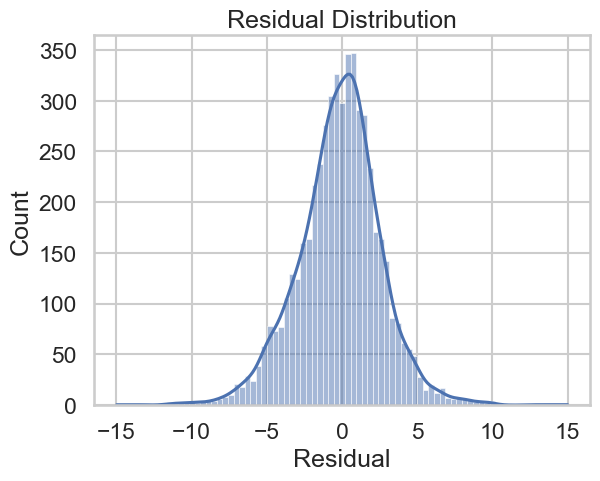

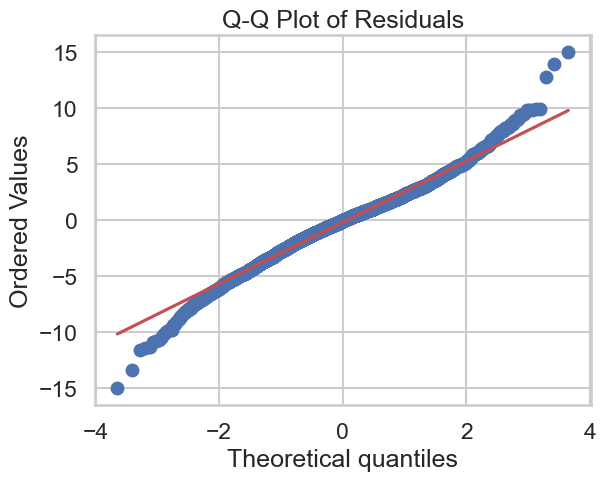

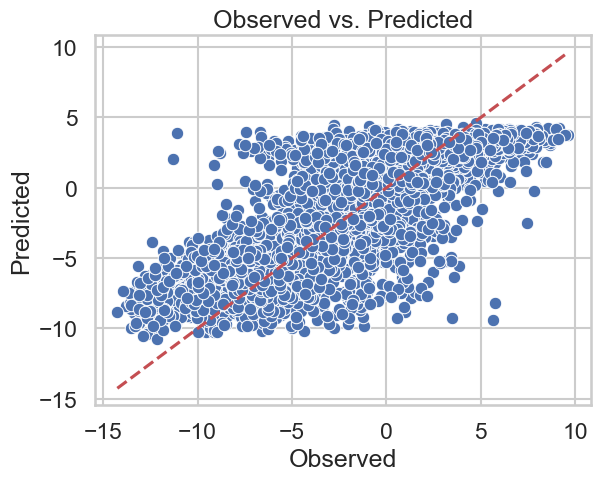

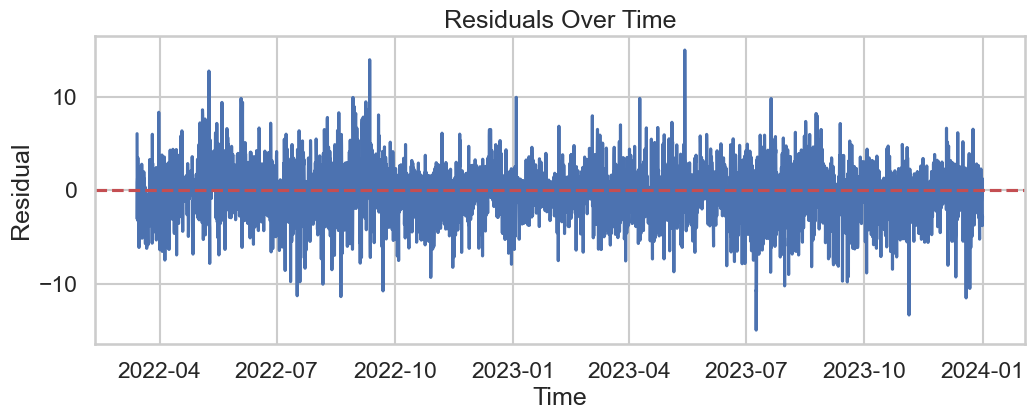

In [114]:
# --- Extended Evaluation ---
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    explained_variance_score,
    mean_absolute_percentage_error
)
from scipy.stats import pearsonr, probplot
import seaborn as sns

residuals = y_test - forecast

mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)
nrmse = rmse / (y_test.max() - y_test.min())
mae = mean_absolute_error(y_test, forecast)
medae = median_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
expl_var = explained_variance_score(y_test, forecast)
mbe = residuals.mean()
r, _ = pearsonr(y_test, forecast)
mape = mean_absolute_percentage_error(y_test, forecast)
smape = 100 * np.mean(2 * np.abs(forecast - y_test) / (np.abs(forecast) + np.abs(y_test)))

metrics = pd.Series({
    "MSE": mse,
    "RMSE": rmse,
    "NRMSE": nrmse,
    "MAE": mae,
    "MedAE": medae,
    "R²": r2,
    "Explained Variance": expl_var,
    "MBE (Bias)": mbe,
    "Pearson R": r,
    "MAPE (%)": mape * 100,
    "sMAPE (%)": smape
})

print("\n=== Extended Evaluation Metrics ===")
print(metrics.round(4))

# Residual Plots
plt.figure()
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.show()

plt.figure()
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

plt.figure()
sns.scatterplot(x=y_test, y=forecast)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs. Predicted")
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(y_test.index, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()